#### Install Modules

In [ ]:
! pip install sentencepiece -q

! pip install transformers -q

! pip install datasets -q

! pip install rouge_score -q

! pip install sacremoses -q

     |████████████████████████████████| 1.3 MB 5.2 MB/s 
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 30.3 MB/s 
     |████████████████████████████████| 120 kB 27.2 MB/s 
     |████████████████████████████████| 365 kB 5.3 MB/s 
     |████████████████████████████████| 115 kB 59.8 MB/s 
     |████████████████████████████████| 212 kB 43.8 MB/s 
     |████████████████████████████████| 127 kB 50.3 MB/s 
     |████████████████████████████████| 880 kB 5.2 MB/s 


In [ ]:
! pip install kaggle -q

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp drive/MyDrive/Kaggle_API_tokens/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600  ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download virajbagal/roco-dataset --force


100% 6.19G/6.19G [01:56<00:00, 108MB/s] 
100% 6.19G/6.19G [01:56<00:00, 57.3MB/s]


In [ ]:
! mkdir ./roco

In [ ]:
! unzip -q roco-dataset.zip -d ./roco 

#### Libraries

In [ ]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path
from transformers import TrainerCallback
from copy import deepcopy
from PIL import Image
import cv2
import numpy as np
import math
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaConfig
from transformers import BertConfig
from transformers import RobertaForMaskedLM
from transformers import BertForMaskedLM 
from transformers import RobertaTokenizerFast 
from transformers import BertTokenizerFast 
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import BertTokenizer
from transformers import DataCollatorForLanguageModeling
from transformers import default_data_collator
from transformers import ViTFeatureExtractor, ViTModel
from transformers import VisionEncoderDecoderModel
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
from textwrap import wrap
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import datetime
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import GPT2LMHeadModel,GPT2Tokenizer,GPT2Config
import unicodedata
import json
import nltk
from tensorflow.keras.utils import plot_model

nltk.download('stopwords')

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')
rouge = datasets.load_metric("rouge")

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### Functions

In [ ]:
def tokenize_seq(sent,tokenizer,max_length):
  '''
    Tokenize the sentence with respect to the sent argument and the tokenizer
  '''
  return tokenizer('<sos>'+ sent + '<eos>', truncation=True, max_length=max_length, padding="max_length")
  
def format_time(elapsed):
    '''
      Calculate the time difference
    '''
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def model_prediction(my_model,image):
  '''
    Return the estimation of the model with respect of the feature extractor and the tokenizer
  '''
  result = tokenizer.decode(my_model.generate(feature_extractor(image, return_tensors="pt",do_normalize = True,image_mean =[0.5, 0.5, 0.5]).pixel_values)[0])
  result = result.replace("<s>", "").replace("</s>", "").replace("<unk>","").replace("</s>","").replace("<pad>","").replace("<s>","").strip()
  return result

def display_score_images(df,my_model,n_limit=3):
  '''
    Return n original images & titles as well as the predictions with respect to the model and the dataframe
  '''
  temp_index_list = df.index.tolist()
  rnumbers = random.sample(range(0,len(temp_index_list)), n_limit)
  my_images = []
  my_titles = []
  my_predictions = []
  for r in rnumbers:
    image = cv2.imread(df.iloc[r]['images'],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_target_size,image_target_size))
    my_images.append(image)
    my_images.append(image)
    my_titles.append(test_df.iloc[r]['captions'])
    my_predictions.append(model_prediction(my_model,image))

  return my_images , my_titles , my_predictions

def display_n_images(im_list,im_title,im_suptitle,n_rows,n_columns):
  '''
  Custom function for displaying images with their titles  
  '''
  w = 10
  h = 10
  fig = plt.figure(figsize=(30,30))
  columns = n_columns
  rows = n_rows
  im_counter = 0
  sup_counter =0
  title_counter =0 
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(im_list[im_counter])
      if im_counter%2 ==0 :
        plt.title(im_title[title_counter],color='green')
        title_counter =  title_counter + 1
      else:
        plt.title(im_suptitle[sup_counter],color='blue')
        sup_counter = sup_counter + 1
      plt.axis('off')
      im_counter = im_counter + 1
  plt.suptitle('Actual vs Predictions',fontsize=80)
  plt.show();

def find_metrics_rouge_history(trainer):
  '''
     According the history of the trainer model, fetch the training as well the validation loss
     as well as the f1 rouge evaluation metrics
  '''
  train_loss_list = []
  train_rouge1_list = []
  train_rouge2_list = []
  val_loss_list = []
  val_rouge1_list = []
  val_rouge2_list = []

  for i,t in enumerate(trainer.state.log_history):
    if t.get('train_runtime') == trainer.state.log_history[-1].get('train_runtime'):
      break
    if 'train_loss' in t.keys():
      train_loss_list.append(t.get('train_loss'))
      train_rouge1_list.append(t['train_rouge1_fmeasure'])
      train_rouge2_list.append(t['train_rouge2_fmeasure'])
    elif 'eval_loss' in t.keys():
      val_loss_list.append(t.get('eval_loss'))
      val_rouge1_list.append(t['eval_rouge1_fmeasure'])
      val_rouge2_list.append(t['eval_rouge2_fmeasure'])

  return train_loss_list , train_rouge1_list , train_rouge2_list ,  val_loss_list , val_rouge1_list , val_rouge2_list


def display_image(img,my_title=None):
  '''
  Custom function to display single image with its title
  '''
  fig, axes = plt.subplots(1, figsize=(15,15))
  if len(img.shape) == 2 : # grayscale , only 1 channel
    plt.imshow(img,cmap='gray')
  else:
    plt.imshow(img)
  if my_title is not None:
    plt.title(my_title) 
  plt.axis('off');

def rmv_empty_images(temp_df,temp_list):
  '''
      According to the list of values and the dataframe, 
      remove all the rows within the dataframe
  '''
  if temp_list is None:
    temp_list =  []
    for i,t in enumerate(temp_df['images'].tolist()):
      image = cv2.imread(t)
      try:
          temp_shape = image.shape
      except Exception:
        temp_list.append(t)
        continue
    temp_df = temp_df[~temp_df.images.isin(temp_list)]
    return temp_df
  else:
    temp_df = temp_df[~temp_df.images.isin(temp_list)]
    return temp_df

def find_metrics_history(trainer):
  '''
     According the history of the trainer model, fetch the training as well the validation loss
  '''
  train_loss_list = []
  train_perplexity_list = []
  val_loss_list = []
  val_perplexity_list = []
  for i,t in enumerate(trainer.state.log_history):
    if t.get('train_runtime') == trainer.state.log_history[-1].get('train_runtime'):
      break
    if 'train_loss' in t.keys():
      train_loss_list.append(t.get('train_loss'))
      train_perplexity_list.append(math.exp(t['train_loss']))
    elif 'eval_loss' in t.keys():
      val_loss_list.append(t.get('eval_loss'))
      val_perplexity_list.append(math.exp(t['eval_loss']))
  return train_loss_list , train_perplexity_list , val_loss_list , val_perplexity_list

def transform_df(df):
  '''
    This is the main transformation function of the process.
    First step is to lowercase all the strings, remove punctioations as well
    as the values within the parenthesis
  '''
  df['captions'] = df['captions'].str.lower()
  df['captions'] = df['captions'].apply(
      lambda elem: elem.replace('\n','').strip())
  df['captions'] = df['captions'].apply(
      lambda elem: re.sub("\(.*?\)","()",elem))
  df['captions'] = df['captions'].apply(
      lambda elem:  re.sub("[\(\[].*?[\)\]]", "", elem))
  df['captions'] = df['captions'].apply(
      lambda elem: re.sub(r'[^\w\s]', "", elem))
  return df

def get_ngrams(review, n, g):
    '''
    Return the Top n words according to the size of the n-gram
    '''
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

def compute_metrics(pred):
    '''
    With respect to the predictions calculate all the rouge 1 
    as well as the rouge 2 evaluation metrics
    '''
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    rouge_output_v1 = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid

    return {
        "rouge1_precision": round(rouge_output_v1.precision, 4),
        "rouge1_recall": round(rouge_output_v1.recall, 4),
        "rouge1_fmeasure": round(rouge_output_v1.fmeasure, 4),
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

def display_score_images_gr(df,my_model,n_limit=3):
  '''
    Return n original images & titles as well as the predictions with respect to the model and the dataframe
    that contains the gr translations of the original captions.
  '''
  temp_index_list = df.index.tolist()
  rnumbers = random.sample(range(0,len(temp_index_list)), n_limit)
  my_images = []
  my_titles = []
  my_predictions = []
  for r in rnumbers:
    image = cv2.imread(df.iloc[r]['images'],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_TARGET_SIZE,IMAGE_TARGET_SIZE))
    my_images.append(image)
    my_images.append(image)
    my_titles.append(df.iloc[r]['captions_gr'] +'\n'+(df.iloc[r]['captions']))
    my_predictions.append(model_prediction(my_model,image))

def create_gr_stopwords(stopwords):
  '''
    Update the nltk greek stopwords with certain words 
  '''
  stopwords = set(stopwords.words('greek'))
  new_stopwords = []
  for s in stopwords:
    new_stopwords.append(strip_accents_and_lowercase(s))
  new_stopwords.append('μια')
  new_stopwords.append('μιας')
  new_stopwords.append('μου')
  new_stopwords.append('ενα')
  new_stopwords.append('σας')
  return new_stopwords

def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

def cleansing_col(main_df):
  '''
  invoke the strip_accents_and_lowercase function and 
  cleanse the captions_gr column that contains the gr translations
  of the original caption column
  '''
  cleansed_data = []
  for v in main_df['captions_gr'].values:
    # new_string = v.translate(str.maketrans('', '', string.punctuation))
    new_string = re.sub(r'http\S+', '', v) #remove urls
    new_string = strip_accents_and_lowercase(new_string)
    new_string = new_string.split(' ')
    new_string = ' '.join(new_string)
    cleansed_data.append(new_string)
  main_df['captions_gr'] = cleansed_data
  return main_df


def validation_score(df):
  '''
   With respect of the dataframe and the model
   return the original captions and the predicted captions
  '''
  true_labels = []
  predicted_labels = []
  for index,record in df.iterrows():
      caption = predict_caption(caption_model, record['images'], tokenizer, max_length, val_features)
      true_labels.append(manipulate_str(record['captions']))
      predicted_labels.append(manipulate_str(caption))
  return predicted_labels , true_labels

def display_score_images_dense(df,my_model,n_limit=3):
  '''
    Return n original images & titles as well as the predictions 
    with respect to the model of the Dense + LSTM architecture
  '''
  temp_index_list = df.index.tolist()
  rnumbers = random.sample(range(0,len(temp_index_list)), n_limit)
  my_images = []
  true_labels = []
  predicted_labels = []
  for r in rnumbers:
    image = cv2.imread(df.iloc[r]['images'],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_target_size,image_target_size))
    my_images.append(image)
    my_images.append(image)
    true_labels.append(manipulate_str (df.iloc[r]['captions']))
    caption = predict_caption(my_model,df.iloc[r]['images'], tokenizer, max_length, val_features)
    predicted_labels.append(manipulate_str(caption))
  return my_images , true_labels , predicted_labels

def predict_caption(model, image, tokenizer, max_length, features):
    '''
    With respect to the Dense+LSTM architecture
    return the predicted caption of the model
    '''
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text+= " " + word
        if word == 'endseq':
            break
    return in_text 

def manipulate_str(my_str):
  '''
  Remove special charactes 
  from the my_str argument
  '''
  temp_str = my_str.replace('startseq',"").replace('\n',"").replace('endseq',"")
  temp_str = temp_str.split(' ')
  return (' '.join(temp_str)).strip()

def idx_to_word(integer,tokenizer):
    '''
    With respect to the tokenizer and the token id 
    return the respective word
    '''
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

#### Data

In [ ]:
## Hyperparameters

TRAIN_BATCH_SIZE = 64  
VALID_BATCH_SIZE = 5   
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4   
SEED = 42               
MAX_LEN = 128            
SUMMARY_LEN = 20         
TRAIN_EPOCHS = 5       
WEIGHT_DECAY = 0.01
SEED = 42               
MAX_LEN = 128
SUMMARY_LEN = 20
BATCH_SIZE= 32   
IMAGE_TARGET_SIZE = 224   

In [ ]:
# Reading the train, test & validation dataframes

train_df = pd.read_csv('/content/roco/all_data/train/radiologytraindata.csv')
train_df.columns = ["id", "images", "captions"]
train_df = train_df[["images", "captions"]]
train_df['images'] = '/content/roco/all_data/{}/radiology/images/'.format('train') + train_df['images']

test_df = pd.read_csv('/content/roco/all_data/test/radiologytestdata.csv')
test_df.columns = ["id", "images", "captions"]
test_df = test_df[["images", "captions"]]
test_df['images'] = '/content/roco/all_data/{}/radiology/images/'.format('test') + test_df['images']


validation_df = pd.read_csv('/content/roco/all_data/validation/radiologyvaldata.csv')
validation_df.columns = ["id", "images", "captions"]
validation_df = validation_df[["images", "captions"]]
validation_df['images'] = '/content/roco/all_data/{}/radiology/images/'.format('validation') + validation_df['images']


print(train_df.shape)
print(test_df.shape)
print(validation_df.shape)

(65450, 2)
(8179, 2)
(8180, 2)


In [ ]:
# Hardcoded list of path images from train,test,validations dataframes
# that do not exist anymore 

val_list =['/content/roco/all_data/validation/radiology/images/PMC2946122_yjbm_83_3_113_g02.jpg',
 '/content/roco/all_data/validation/radiology/images/PMC3277920_PHLEB-10-100-g2.jpg',
 '/content/roco/all_data/validation/radiology/images/PMC5754747_f1000research-6-14507-g0001.jpg',
 '/content/roco/all_data/validation/radiology/images/PMC4887302_12471_2016_832_Fig2_HTML.jpg',
 '/content/roco/all_data/validation/radiology/images/PMC4467246_icrp2_43_f2.jpg']


train_list = ['/content/roco/all_data/train/radiology/images/PMC2892771_yjbm_83_2_67_g01.jpg',
 '/content/roco/all_data/train/radiology/images/PMC3999928_f1000research-3-4060-g0002.jpg',
 '/content/roco/all_data/train/radiology/images/PMC2892763_yjbm_83_2_73_g01.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4445437_yjbm_88_2_157_g06.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5754747_f1000research-6-14507-g0003.jpg',
 '/content/roco/all_data/train/radiology/images/PMC3999928_f1000research-3-4060-g0001.jpg',
 '/content/roco/all_data/train/radiology/images/PMC3999928_f1000research-3-4060-g0000.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5407183_ofw26702.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5569400_05-i004a.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5241049_nihms839240f3.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4240561_MA-68-291-g002.jpg',
 '/content/roco/all_data/train/radiology/images/PMC3941458_yjbm_87_1_3_g01.jpg',
 '/content/roco/all_data/train/radiology/images/PMC3999928_f1000research-3-4060-g0003.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4345544_yjbm_88_1_93_g05.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5529052_nihms879007f1.jpg',
 '/content/roco/all_data/train/radiology/images/PMC2946122_yjbm_83_3_113_g01.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4603610_amjcaserep-16-715-g003.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4156025_f1000research-3-3454-g0000.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4603610_amjcaserep-16-715-g002.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5628629_RCR2-5-na-g002.jpg',
 '/content/roco/all_data/train/radiology/images/PMC2890366_zdc0071083540001.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5569400_05-i004b.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4043289_nihms586074f2.jpg',
 '/content/roco/all_data/train/radiology/images/PMC3483062_noph36-149-f1.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5754747_f1000research-6-14507-g0000.jpg',
 '/content/roco/all_data/train/radiology/images/PMC5218828_nihms839236f3.jpg',
 '/content/roco/all_data/train/radiology/images/PMC3892916_f1000research-2-1897-g0002.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4345544_yjbm_88_1_93_g03.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4345544_yjbm_88_1_93_g04.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4728737_emss-66793-f0004.jpg',
 '/content/roco/all_data/train/radiology/images/PMC4887302_12471_2016_832_Fig1_HTML.jpg']

test_list = ['/content/roco/all_data/test/radiology/images/PMC5241049_nihms839240f4.jpg',
 '/content/roco/all_data/test/radiology/images/PMC5357066_emss-71420-f001.jpg',
 '/content/roco/all_data/test/radiology/images/PMC4544285_anec0019-0193-f3.jpg']

In [ ]:
# remove the rows of the certain image paths that to do not exist
train_df = rmv_empty_images(train_df,temp_list=train_list)
test_df = rmv_empty_images(test_df,temp_list=test_list)
validation_df = rmv_empty_images(validation_df,temp_list=val_list)

print(train_df.shape)
print(test_df.shape)
print(validation_df.shape)

# cleansing the caption column of the dataframe
train_df = transform_df(train_df)
test_df = transform_df(test_df)
validation_df = transform_df(validation_df)

(65419, 2)
(8176, 2)
(8175, 2)


#### Data Visualizations

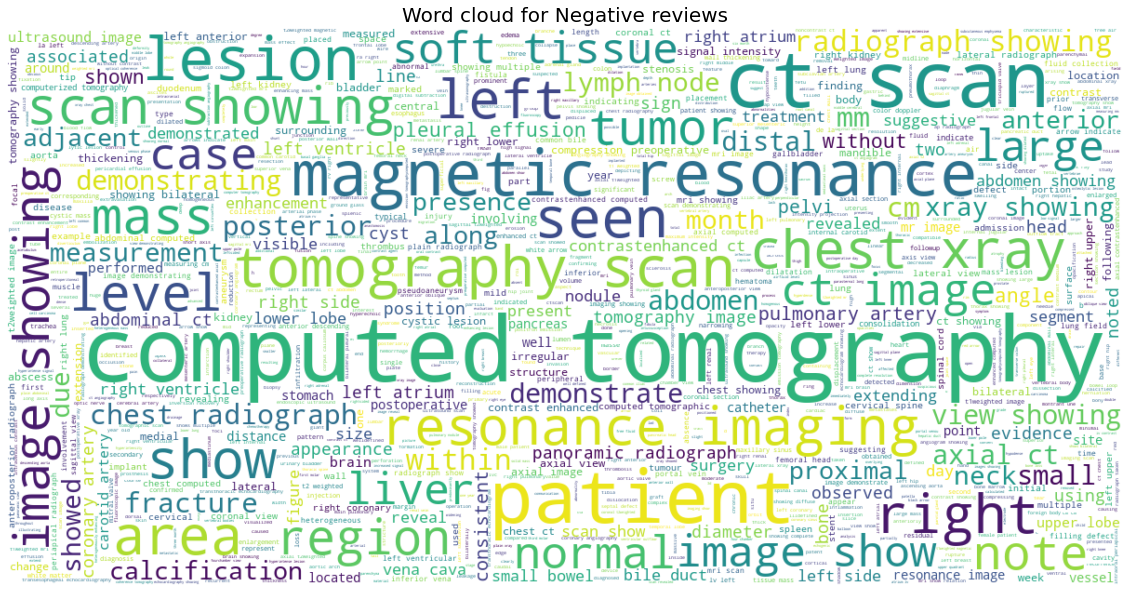

In [ ]:
# Creating wordcloud based on the caption of the train dataframe
# in this we can visualize the most import words of the corpus

uni_data = train_df['captions']
uni_data_string = ' '.join(uni_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="white",stopwords=STOPWORDS).generate(uni_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Negative reviews',fontsize = 20)
plt.show()

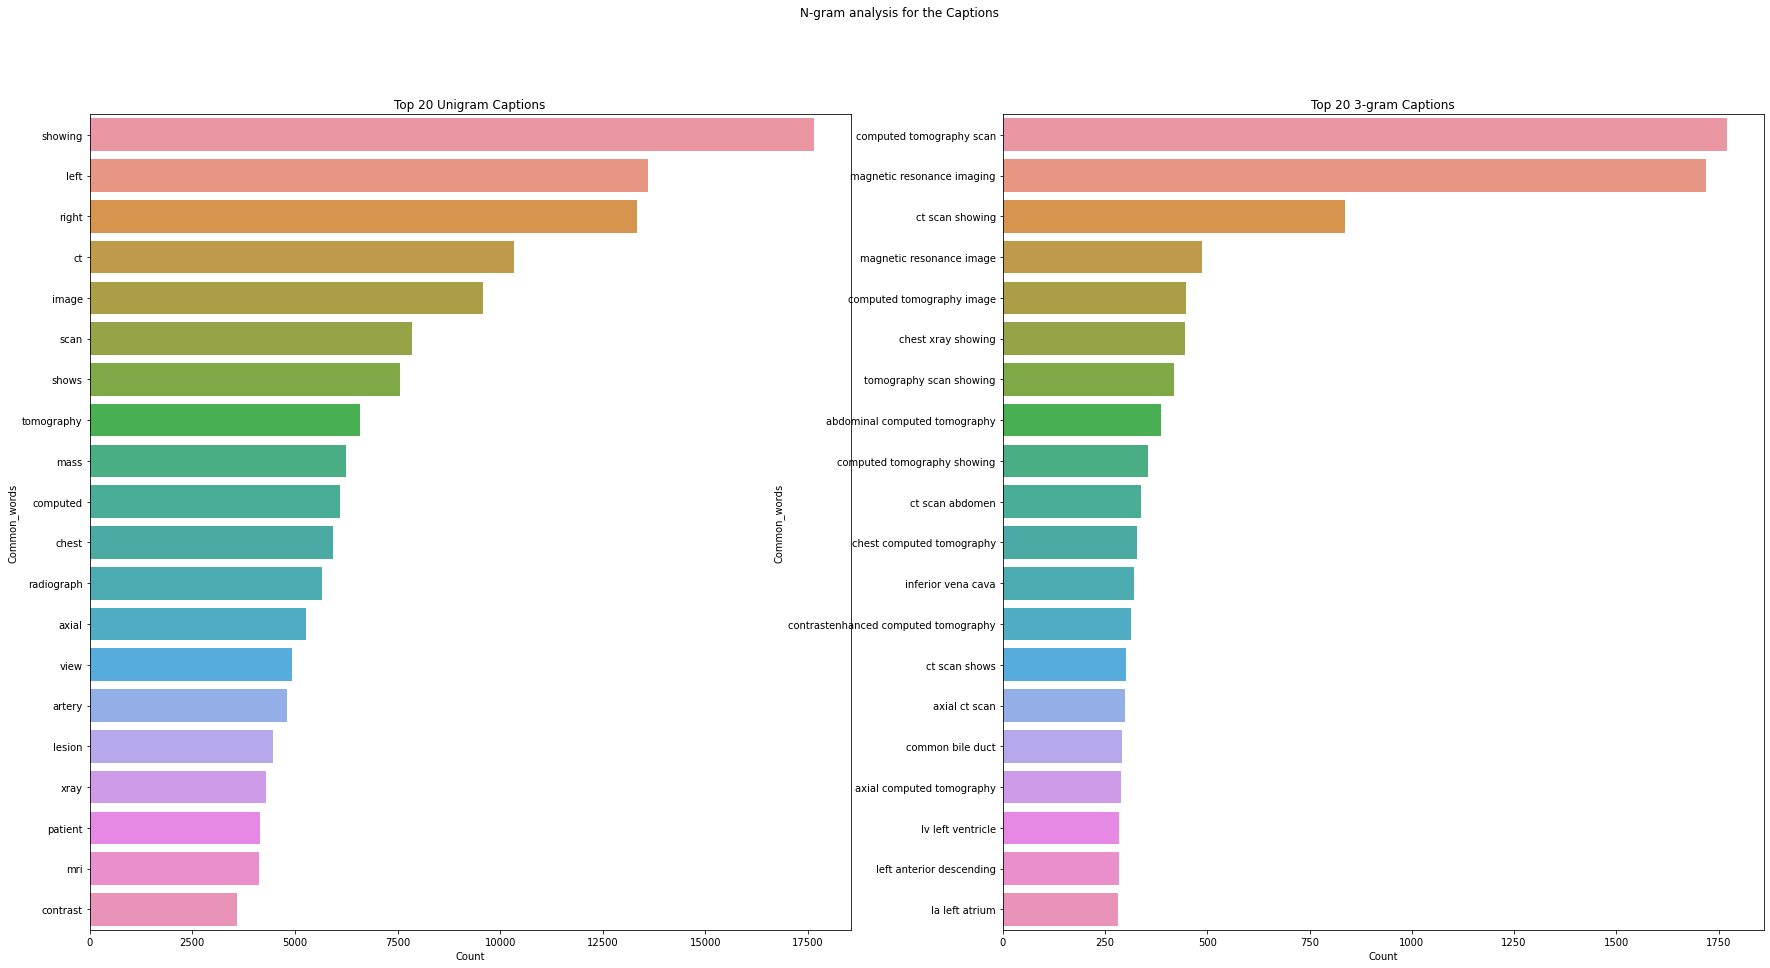

In [ ]:
# visualing the top 20 words / phrases of the unigram the the 3gram respectively

uni_data = train_df['captions']
uni_data = uni_data.to_frame()
uni_data['captions'] = uni_data['captions'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))

bi_negative = get_ngrams(uni_data['captions'],20,1)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax=ax1)

bi_neutral = get_ngrams(uni_data['captions'],20,3)
bi_neutral = dict(bi_neutral)
temp = pd.DataFrame(list(bi_neutral.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax=ax2)


ax1.set_title('Top 20 Unigram Captions')
ax2.set_title('Top 20 3-gram Captions')
fig.suptitle('N-gram analysis for the Captions')
plt.show()

### DenseNet + LSTM

In [ ]:
# Train the tokenizer with the respective captions
# compute the vocabulary size and the max length of the tokens
union_df = train_df.append(validation_df, ignore_index=True)
captions = union_df['captions'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# define the target size of the image
image_target_size = 224

# define the DenseNet model with 200 layers
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# extracting all the features of the image based on the DenseNet
# both from training and validation and store them in dictionaries
print('Extracting Features from training set')
features = {}
for image_path in tqdm(train_df['images'].tolist()):
    image = cv2.imread(image_path,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(image, (image_target_size,image_target_size))
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image_path] = feature

print('Extracting Features from validation set')
val_features = {}
for image_path in tqdm(validation_df['images'].tolist()):
    image = cv2.imread(image_path,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(image, (image_target_size,image_target_size))
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    val_features[image_path] = feature

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()
        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)                
        return X1, X2, y

In [ ]:
# define the structure of the model
# define the shape of the features from the Densenet and concatenate with the captions
# apply LSTM with dense layers and dropouts
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# define the input and ouput and compile the model
caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

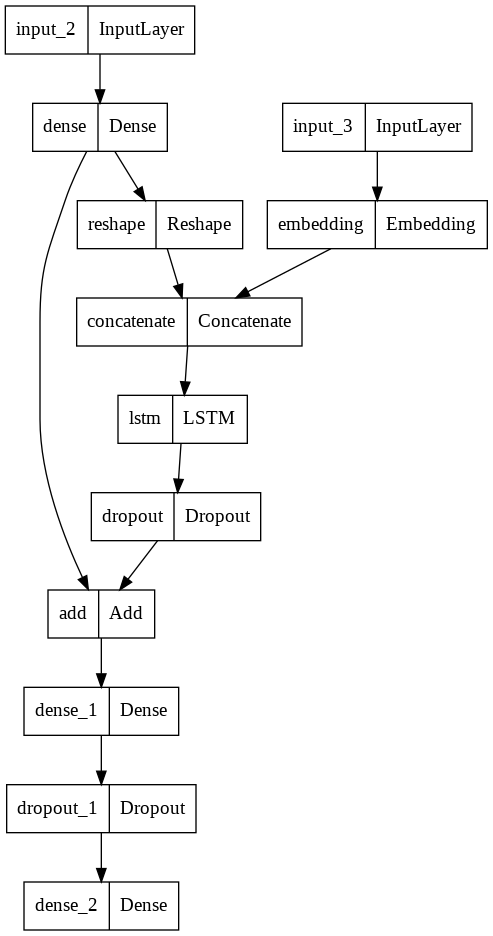

In [ ]:
# visualizing the architecture of the model

plot_model(caption_model)

In [ ]:
# invoke the CustomDataGenerator with respect of the train dataframe the tokenizer and the respective features
train_generator = CustomDataGenerator(df=train_df,X_col='images',y_col='captions',batch_size=64,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# invoke the CustomDataGenerator with respect of the validations dataframe the tokenizer and the respective features
validation_generator = CustomDataGenerator(df=validation_df,X_col='images',y_col='captions',batch_size=64,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=val_features)

In [ ]:
# apply earlystopping and saving the best model according to the validation loss

model_name = "caption_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 4, verbose = 1, restore_best_weights=True)

In [ ]:
# training the model with 20 epochs and earlystopping 
history = caption_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping])

Epoch 1/20
1022/1022 [==============================] - ETA: 0s - loss: 6.2125
Epoch 1: val_loss improved from inf to 5.45918, saving model to caption_model.h5
1022/1022 [==============================] - 486s 472ms/step - loss: 6.2125 - val_loss: 5.4592
Epoch 2/20
1022/1022 [==============================] - ETA: 0s - loss: 5.4285
Epoch 2: val_loss improved from 5.45918 to 5.09549, saving model to caption_model.h5
1022/1022 [==============================] - 482s 472ms/step - loss: 5.4285 - val_loss: 5.0955
Epoch 3/20
1022/1022 [==============================] - ETA: 0s - loss: 5.1156
Epoch 3: val_loss improved from 5.09549 to 4.90086, saving model to caption_model.h5
1022/1022 [==============================] - 482s 472ms/step - loss: 5.1156 - val_loss: 4.9009
Epoch 4/20
1022/1022 [==============================] - ETA: 0s - loss: 4.9164
Epoch 4: val_loss improved from 4.90086 to 4.79115, saving model to caption_model.h5
1022/1022 [==============================] - 483s 473ms/step - 

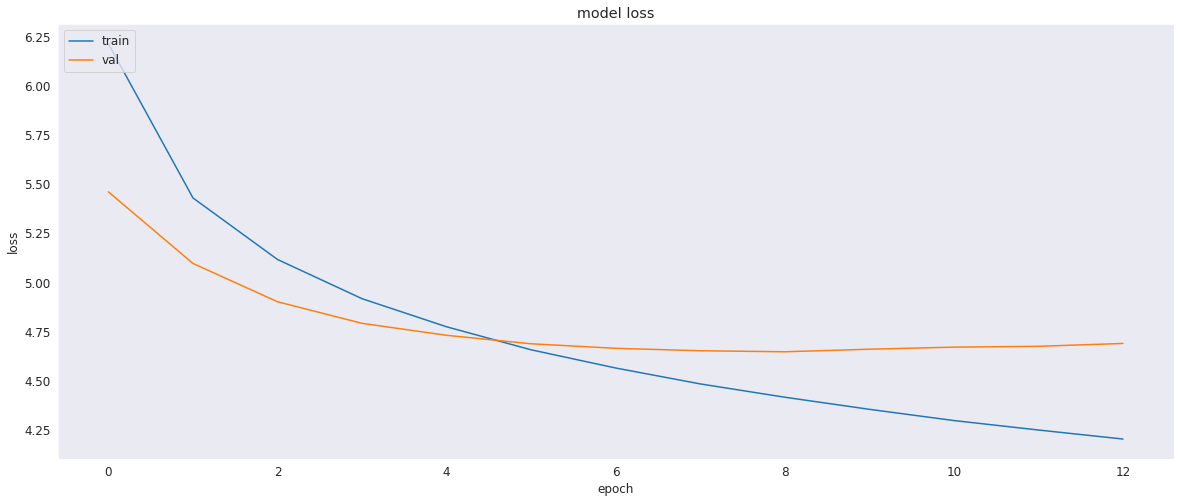

In [ ]:
# plot the training and validation loss across the epochs
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# display images along with the original captions as well as the predicted captions
my_images , true_labels , predicted_labels = display_score_images_dense(df=validation_df,my_model=caption_model,n_limit=4)

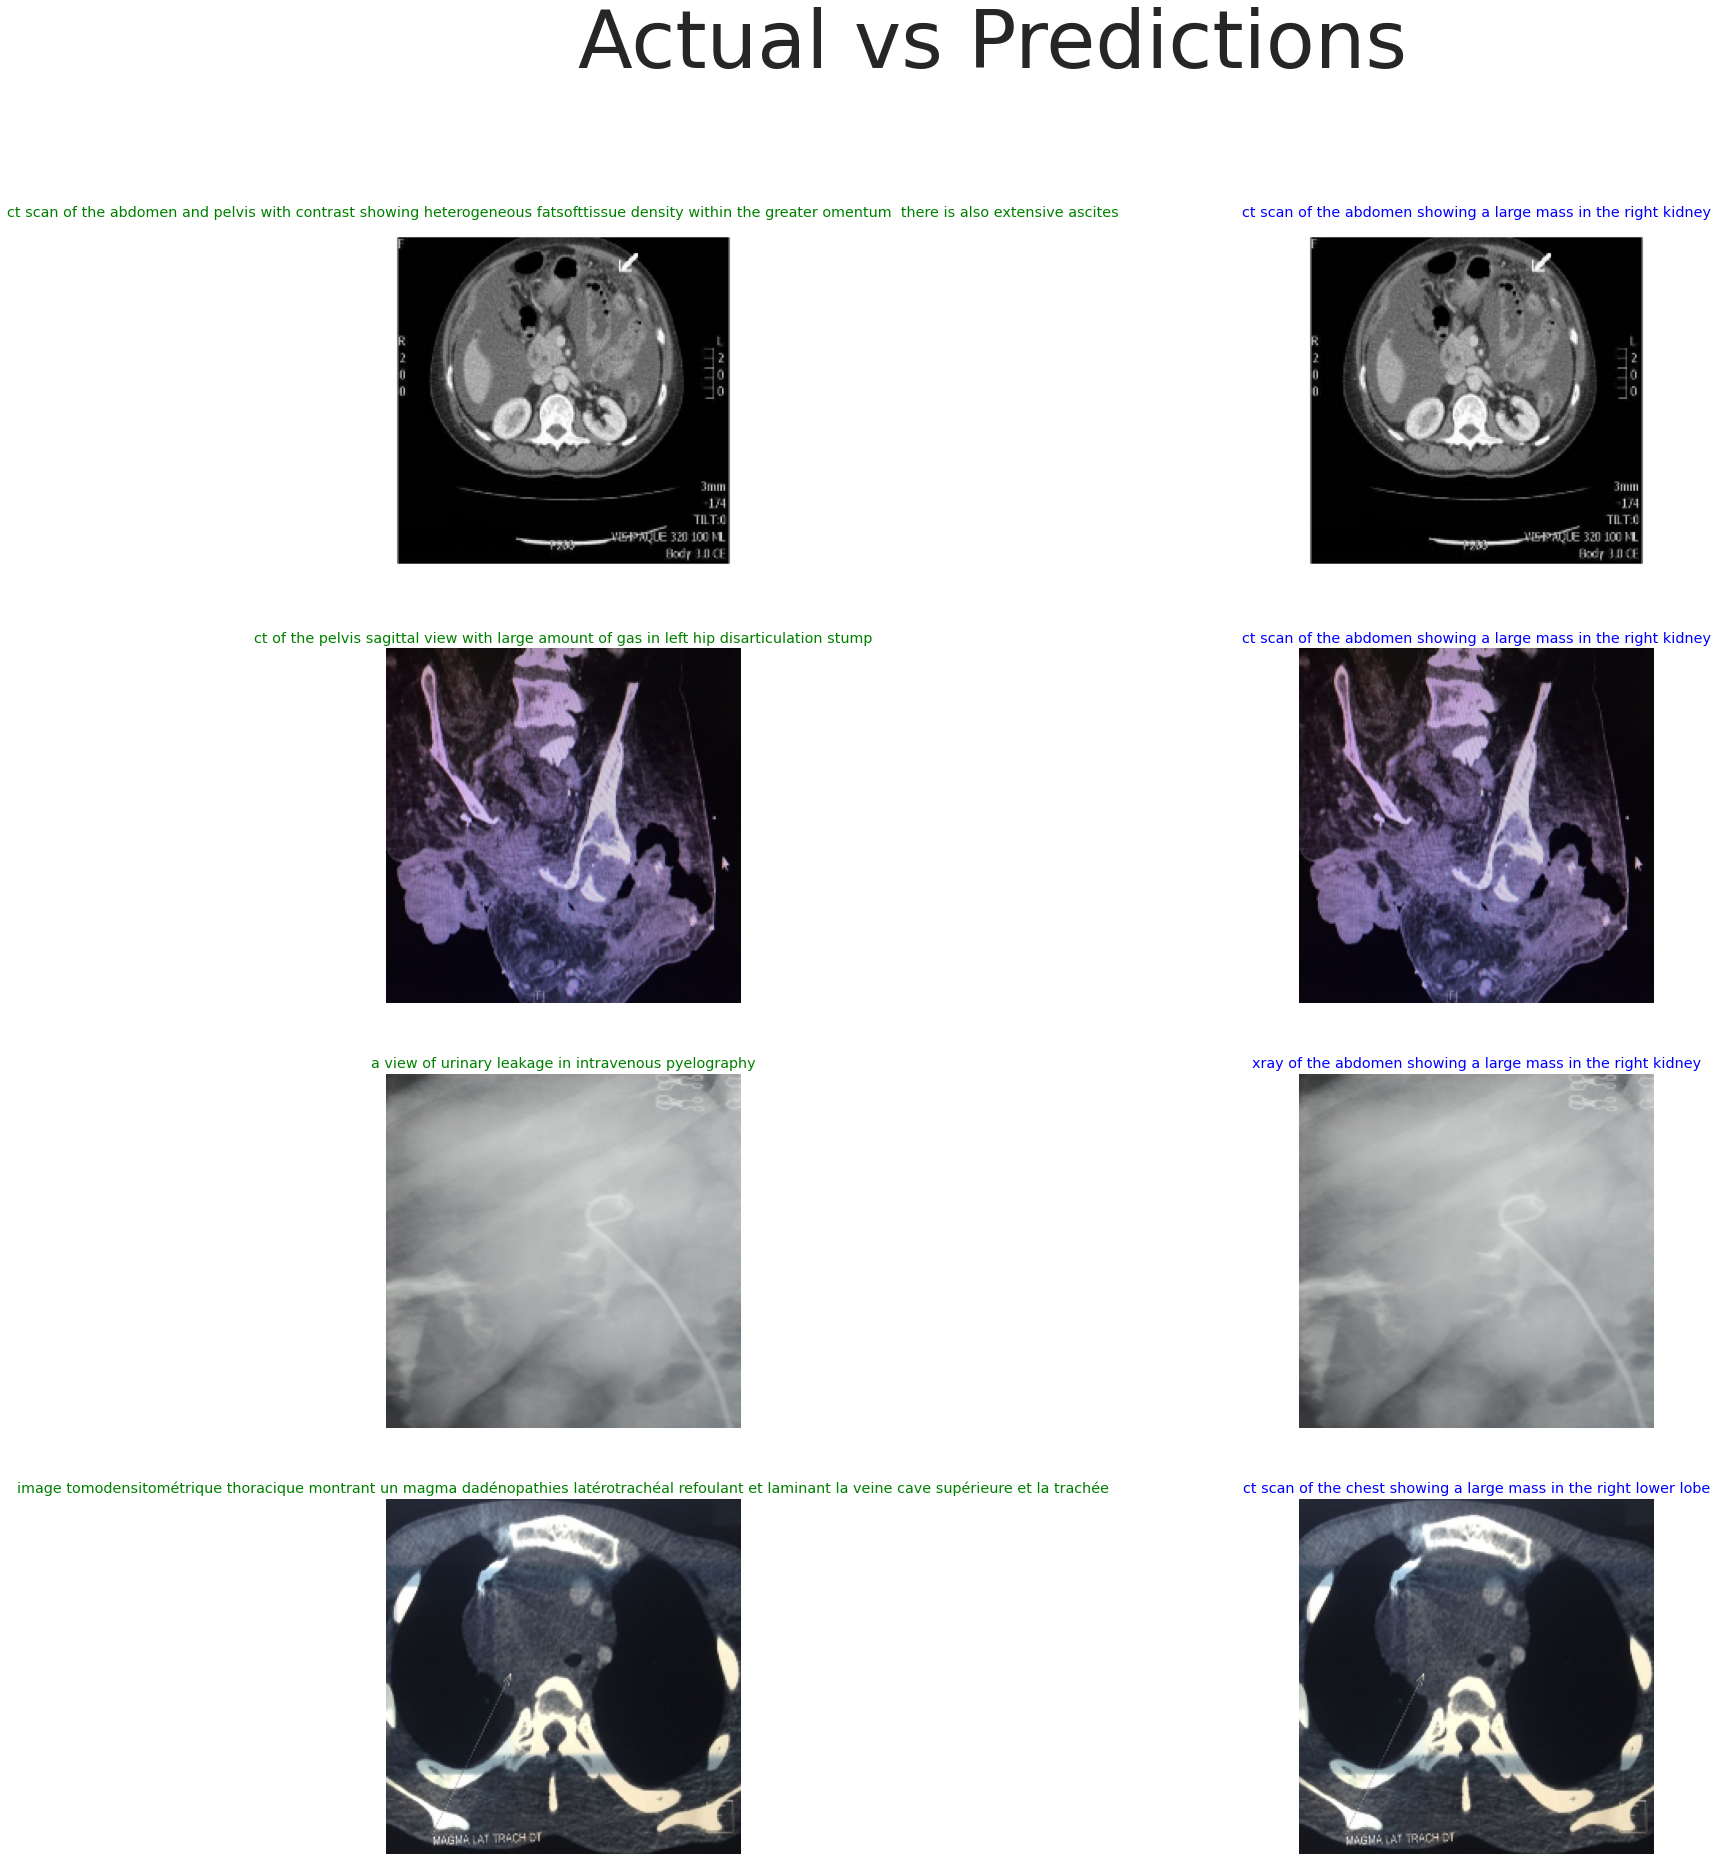

In [ ]:
display_n_images(my_images,im_title=true_labels,im_suptitle=predicted_labels,n_rows=4,n_columns=2)

In [ ]:
# display images along with the original captions as well as the predicted captions

my_images , true_labels , predicted_labels = display_score_images_dense(df=validation_df,my_model=caption_model,n_limit=4)

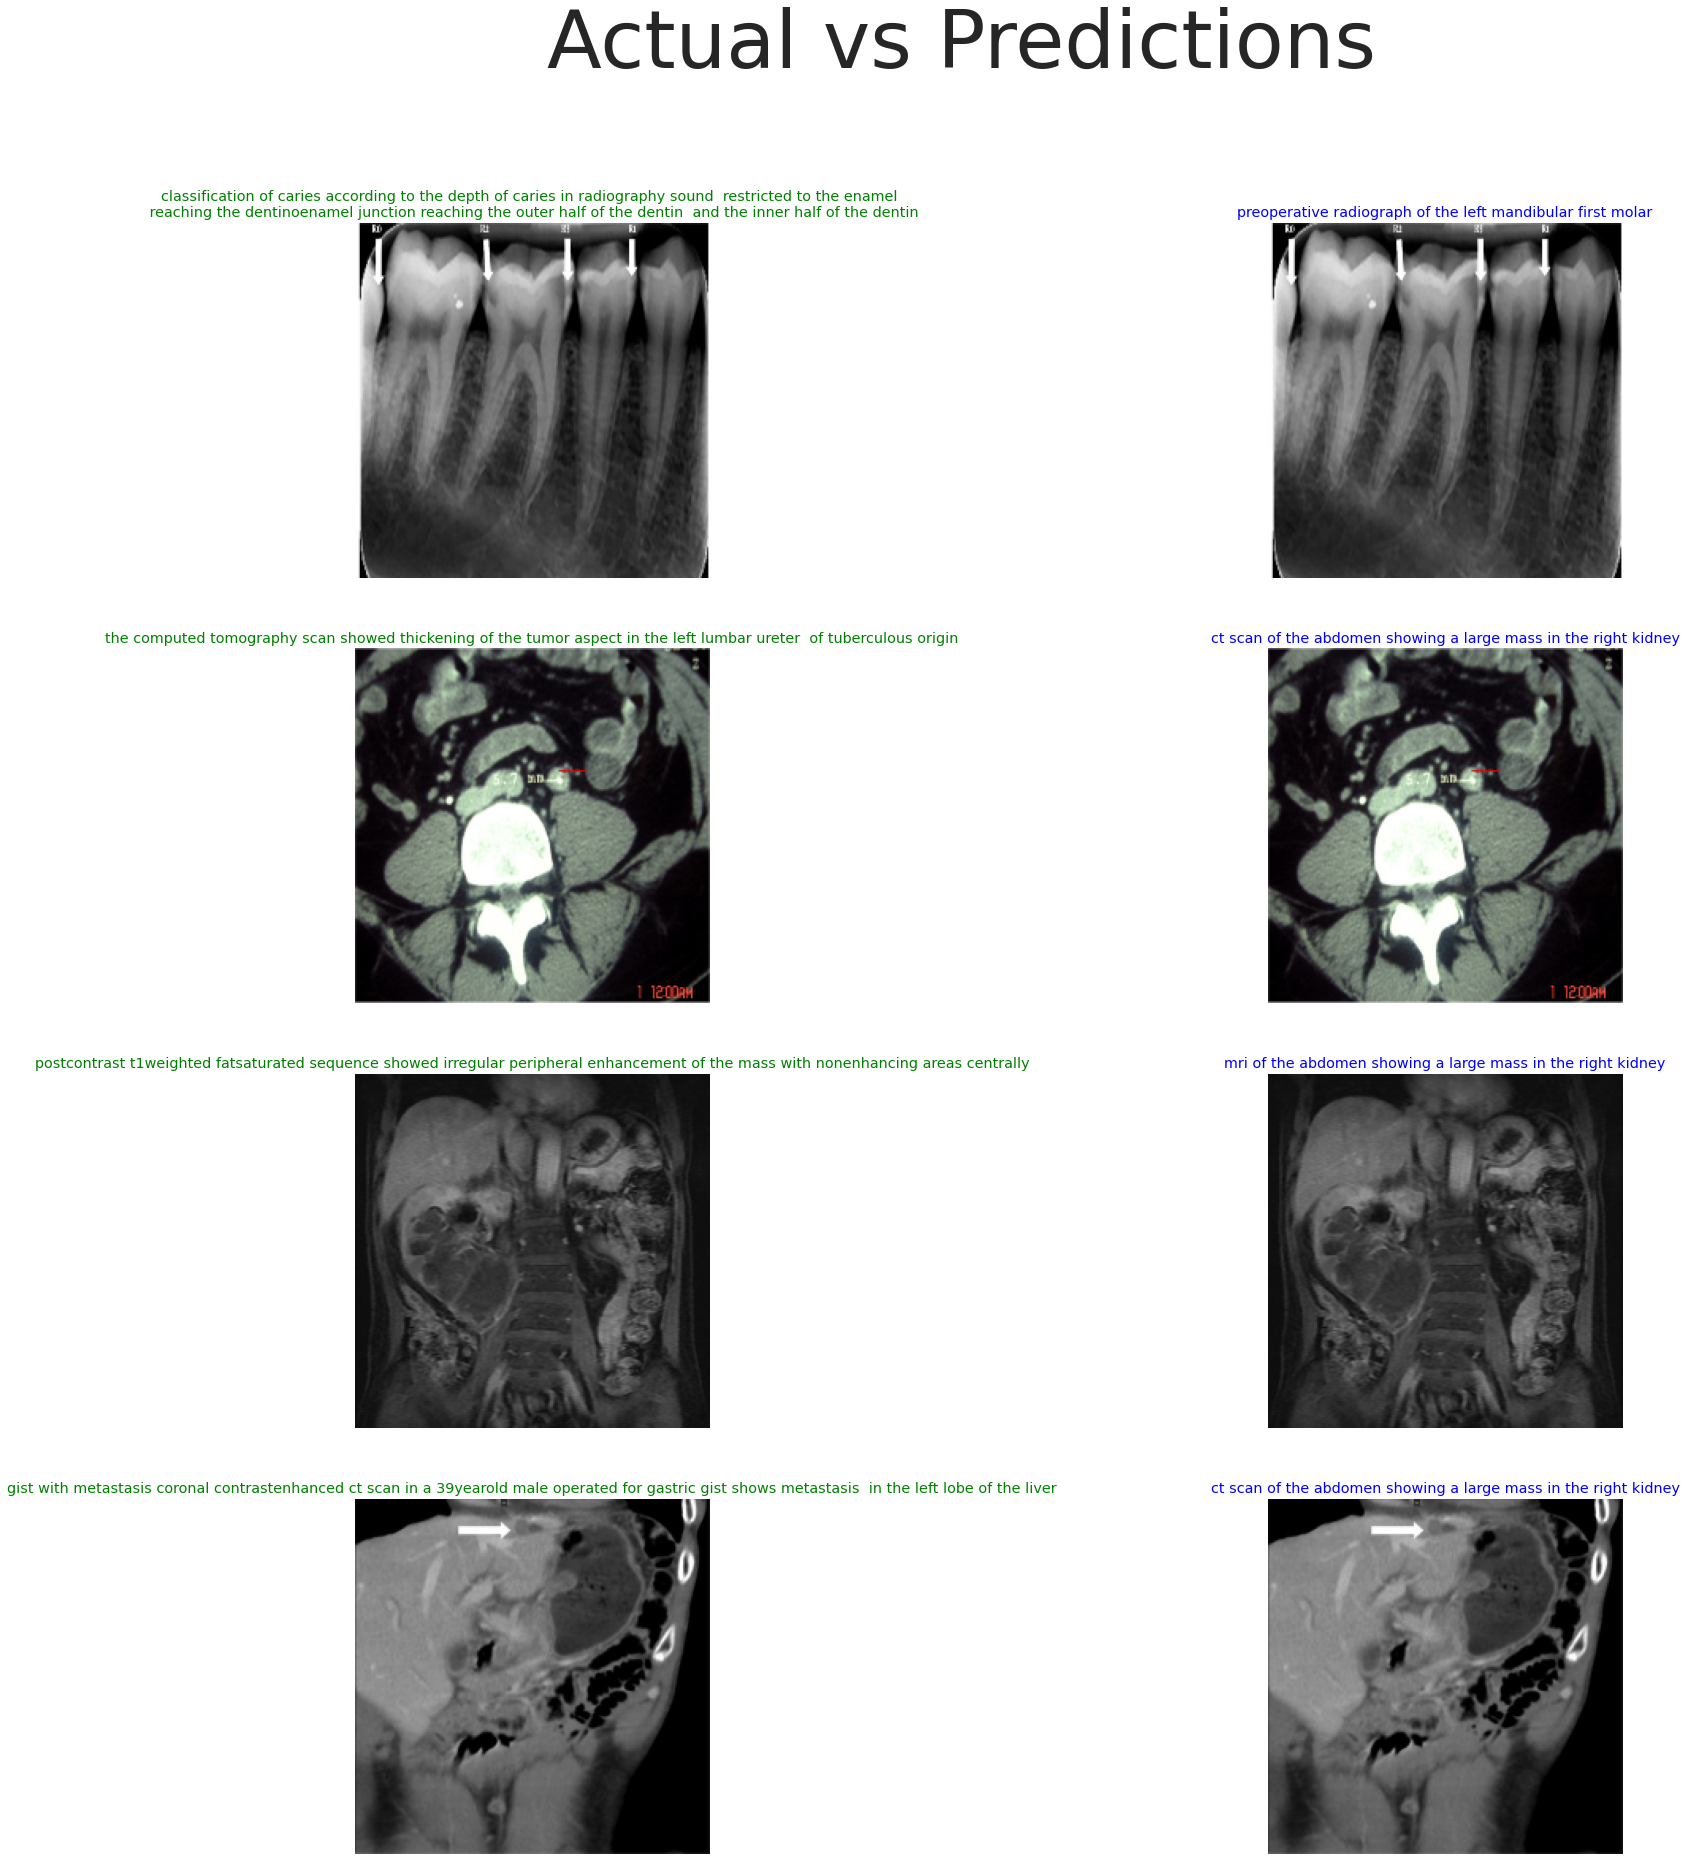

In [ ]:
display_n_images(my_images,im_title=true_labels,im_suptitle=predicted_labels,n_rows=4,n_columns=2)

In [ ]:
# compute the predicted captions with respect to a subset of the validation dataframe
predicted_labels , true_labels = validation_score(validation_df.head(1000))

In [ ]:
# calculate the rouge f1,recall,precision based on the predictions
rouge_output_f1 = rouge.compute(predictions=predicted_labels, references=true_labels, rouge_types=["rouge1"])["rouge1"].high.fmeasure
rouge_output_recall = rouge.compute(predictions=predicted_labels, references=true_labels, rouge_types=["rouge1"])["rouge1"].high.recall
rouge_output_precision = rouge.compute(predictions=predicted_labels, references=true_labels, rouge_types=["rouge1"])["rouge1"].high.precision

### Roberta + VIT

##### Decoder Roberta

In [ ]:
# fetch the pretrained Roberta tokenizer and mlm model from Hugging face
model = RobertaForMaskedLM.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('roberta-base', max_len=MAX_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


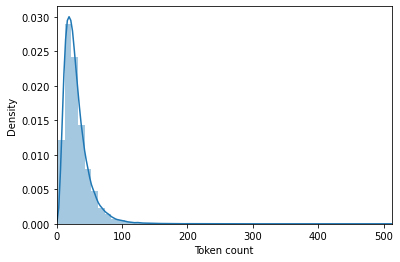

In [ ]:
# plot the token lenthgs to visualize the distribution and focus on the max length of the tokenizer
dummy_tokenizer = AutoTokenizer.from_pretrained('roberta-base', max_len=512)
token_lens = []

for txt in train_df.captions.to_list():
  tokens = dummy_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.examples = []
        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = MAX_LEN, truncation=True, padding=True)
            self.examples += [x.input_ids]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i])

In [ ]:
# invoke the CustomDataset for training and validation datasets
train_dataset = CustomDataset(train_df['captions'], tokenizer)
eval_dataset = CustomDataset(validation_df['captions'], tokenizer)

# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

In [ ]:
# define the customcallback for the trainer
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [ ]:
model_folder = "RoBERTa"
# Define the training arguments
training_args = TrainingArguments(
    output_dir=model_folder,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    save_steps=8192,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
# add a callback to the trainer
trainer.add_callback(CustomCallback(trainer)) 


In [ ]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 65419
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10230


***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running

TrainOutput(global_step=10230, training_loss=1.6619435359772117, metrics={'train_runtime': 11018.8547, 'train_samples_per_second': 59.37, 'train_steps_per_second': 0.928, 'total_flos': 3.4361373818639932e+16, 'train_loss': 1.6619435359772117, 'epoch': 10.0})

In [ ]:
train_loss_list , train_perplexity_list , val_loss_list , val_perplexity_list = find_metrics_history(trainer)

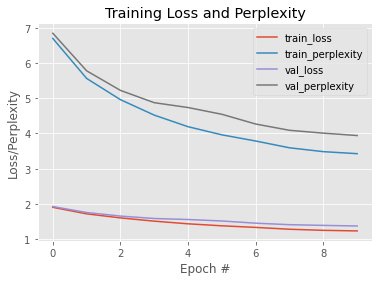

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model along with ther perplexities
N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), train_perplexity_list, label="train_perplexity")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.plot(np.arange(0, N), val_perplexity_list, label="val_perplexity")
plt.title("Training Loss and Perplexity")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Perplexity")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
print('Saving trained model & tokenizer')
print()
trainer.save_model(model_folder)
print()
tokenizer.save_pretrained(model_folder + '_tokenizer')


Saving model checkpoint to RoBERTa
Configuration saved in RoBERTa/config.json


Saving trained model & tokenizer



Model weights saved in RoBERTa/pytorch_model.bin
tokenizer config file saved in RoBERTa_tokenizer/tokenizer_config.json
Special tokens file saved in RoBERTa_tokenizer/special_tokens_map.json


('RoBERTa_tokenizer/tokenizer_config.json',
 'RoBERTa_tokenizer/special_tokens_map.json',
 'RoBERTa_tokenizer/vocab.json',
 'RoBERTa_tokenizer/merges.txt',
 'RoBERTa_tokenizer/added_tokens.json',
 'RoBERTa_tokenizer/tokenizer.json')

In [ ]:
# Evaluate Language Model
fill_mask = pipeline(
    "fill-mask",
    model= model_folder,
    tokenizer= model_folder + '_tokenizer')

hardcoded_masked_list = [
{'masked' : '<mask> appearance in sonography', 'unmasked': 'Hydronephrosis'},
{'masked' :'focal steatosis of the <mask> parenchyma' , 'unmasked': 'liver'},
{'masked' :'showing the subtrochanteric fracture in the porotic <mask>' ,  'unmasked': 'bone'},
{'masked' :'computed tomography <mask> in axial view showing obliteration of the left maxillary sinus'  ,  'unmasked': 'scan'},
{'masked' :'view of giant cell <mask> of thumb metacarpal preoperatively' ,  'unmasked': 'tumor'},
{'masked' :'<mask> showing high signals involving the superior sagittal sinus thrombosis on TW1' , 'unmasked': 'MRI'},
{'masked' :'mdct angiography showing the <mask> of coa in a 1-month-old girl' ,  'unmasked': 'location'},
{'masked' : 'chest radiograph obtained after endoscopic submucosal <mask> showing left pleural fluid with subsegmental collapse of the left lower lobe', 'unmasked': 'dissection'},
{'masked' :'case 2 tibial <mask>' ,  'unmasked': 'fracture'},
{'masked' :'computerised tomographic scan chest showing <mask>' ,  'unmasked': 'tumor'},
{'masked' :'xray of the septic acl reconstructed <mask>' ,  'unmasked': 'knee'},
{'masked' :'pelvic mri two months after completion of <mask> therapy reveals no inflammatory change' ,  'unmasked': 'antibiotic'},
{'masked' :'radiograph of the affected <mask> at 4 weeks' ,  'unmasked': 'shoulder'},
{'masked' :'near infraredautofluorescence image of a normal right <mask>' ,  'unmasked': 'eye'},
{'masked' :'ap of the right hip following hemiarthroplasty <mask>' ,  'unmasked': 'surgery'},
{'masked' :'preoperative abdominal ct massive <mask> hydatid cyst replacing segments iv to viii' ,  'unmasked': 'liver'},
{'masked' :'xray of the septic acl reconstructed <mask>' ,  'unmasked': 'knee'},
]

In [ ]:
for h in hardcoded_masked_list:
  print('masked sentence : {}'.format(h.get('masked')))
  print('unmasked word : {}'.format(h.get('unmasked')))
  result = fill_mask(h.get('masked'))[0]
  print('predicted word : \"{}\" with maximum score : {}'.format(result.get('token_str'),result.get('score')))
  print()


masked sentence : <mask> appearance in sonography
unmasked word : Hydronephrosis
predicted word : "normal" with maximum score : 0.6298666596412659

masked sentence : focal steatosis of the <mask> parenchyma
unmasked word : liver
predicted word : " liver" with maximum score : 0.8790934085845947

masked sentence : showing the subtrochanteric fracture in the porotic <mask>
unmasked word : bone
predicted word : " region" with maximum score : 0.18236856162548065

masked sentence : computed tomography <mask> in axial view showing obliteration of the left maxillary sinus
unmasked word : scan
predicted word : " scan" with maximum score : 0.6919050216674805

masked sentence : view of giant cell <mask> of thumb metacarpal preoperatively
unmasked word : tumor
predicted word : " tumor" with maximum score : 0.49643972516059875

masked sentence : <mask> showing high signals involving the superior sagittal sinus thrombosis on TW1
unmasked word : MRI
predicted word : "image" with maximum score : 0.198

##### Decoder Roberta + Encoder ViT

In [ ]:
# fetch the pretrained Roberta tokenizer and feature extractor from VIT

model_folder = "RoBERTa"

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained(model_folder + '_tokenizer',max_len=MAX_LEN)

In [ ]:
class ROCO_Dataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]

        image = cv2.imread(img_path,1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_TARGET_SIZE,IMAGE_TARGET_SIZE))

        pixel_values = self.feature_extractor(image, return_tensors="pt",do_normalize = True,
                                              image_mean =[0.5, 0.5, 0.5]).pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length", 
                                          max_length=self.decoder_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
# invoke the ROCO_Dataset for training and validation datasets
train_dataset = ROCO_Dataset(df=train_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = ROCO_Dataset(df=validation_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

In [ ]:
# define VisionEncoderDecoderModel with the respective encoder and decoder
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k",model_folder, tie_encoder_decoder=True)

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at RoBERTa and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.6.crossattention.self.key.bias', 'roberta.encoder.layer.2.crossattention.self.key.weight', 'roberta.encoder.layer.6.crossattention.self.value.bias', 'roberta.encoder.layer.3.crossattention.self.value.weight', 'roberta.encoder.layer.11.crossattention.self.value.bias', 'roberta.encoder.layer.10.crossattention.self.query.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.7.crossattention.self.query.bias', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.self.query.weight', 'roberta.encoder.layer.5.crossattention.self.value.weight', 'roberta.encoder.layer.4.crossattention.self.query.bias', 'roberta.encoder.layer.2.crossattention.output.dense.bias', 'roberta.encoder.layer.9.crossattention.outpu

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size


# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 30 # modified
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
captioning_model = 'VIT_Captioning'
# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)


# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [ ]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 65419
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 10225


***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-2048
Configuration saved in VIT_Captioning/checkpoint-2048/config.json
Model weights saved in VIT_Captioning/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-2048/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-4096
Configuration saved in VIT_Captioning/checkpoint-4096/config.json
Model weights saved in VIT_Captioning/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_Captioning/checkpoint-2048] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-6144
Configuration saved in VIT_Captioning/checkpoint-6144/config.json
Model weights sav

TrainOutput(global_step=10225, training_loss=2.843248729752445, metrics={'train_runtime': 15720.5121, 'train_samples_per_second': 20.807, 'train_steps_per_second': 0.65, 'total_flos': 5.9218613321809215e+19, 'train_loss': 2.843248729752445, 'epoch': 5.0})

In [ ]:
train_loss_list , train_rouge1_list , train_rouge2_list ,  val_loss_list , val_rouge1_list , val_rouge2_list = find_metrics_rouge_history(trainer)

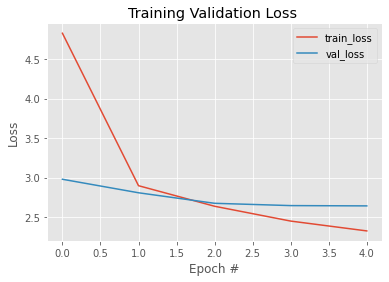

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model 
N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.title("Training Validation Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

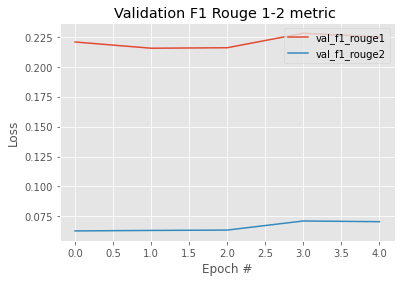

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation rouge1 metrics

N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), val_rouge1_list, label="val_f1_rouge1")
plt.plot(np.arange(0, N), val_rouge2_list, label="val_f1_rouge2")
plt.title("Validation F1 Rouge 1-2 metric ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
trainer.save_model('VIT_Captioning'+'_'+model_folder)

Saving model checkpoint to VIT_Captioning_RoBERTa
Configuration saved in VIT_Captioning_RoBERTa/config.json
Model weights saved in VIT_Captioning_RoBERTa/pytorch_model.bin
Feature extractor saved in VIT_Captioning_RoBERTa/preprocessor_config.json


In [ ]:
# load the model
load_model = VisionEncoderDecoderModel.from_pretrained('VIT_Captioning'+'_'+model_folder)

In [ ]:
# display images along with the original captions as well as the predicted captions

my_images , my_titles , my_predictions = display_score_images(df=test_df,my_model=load_model,n_limit=4)

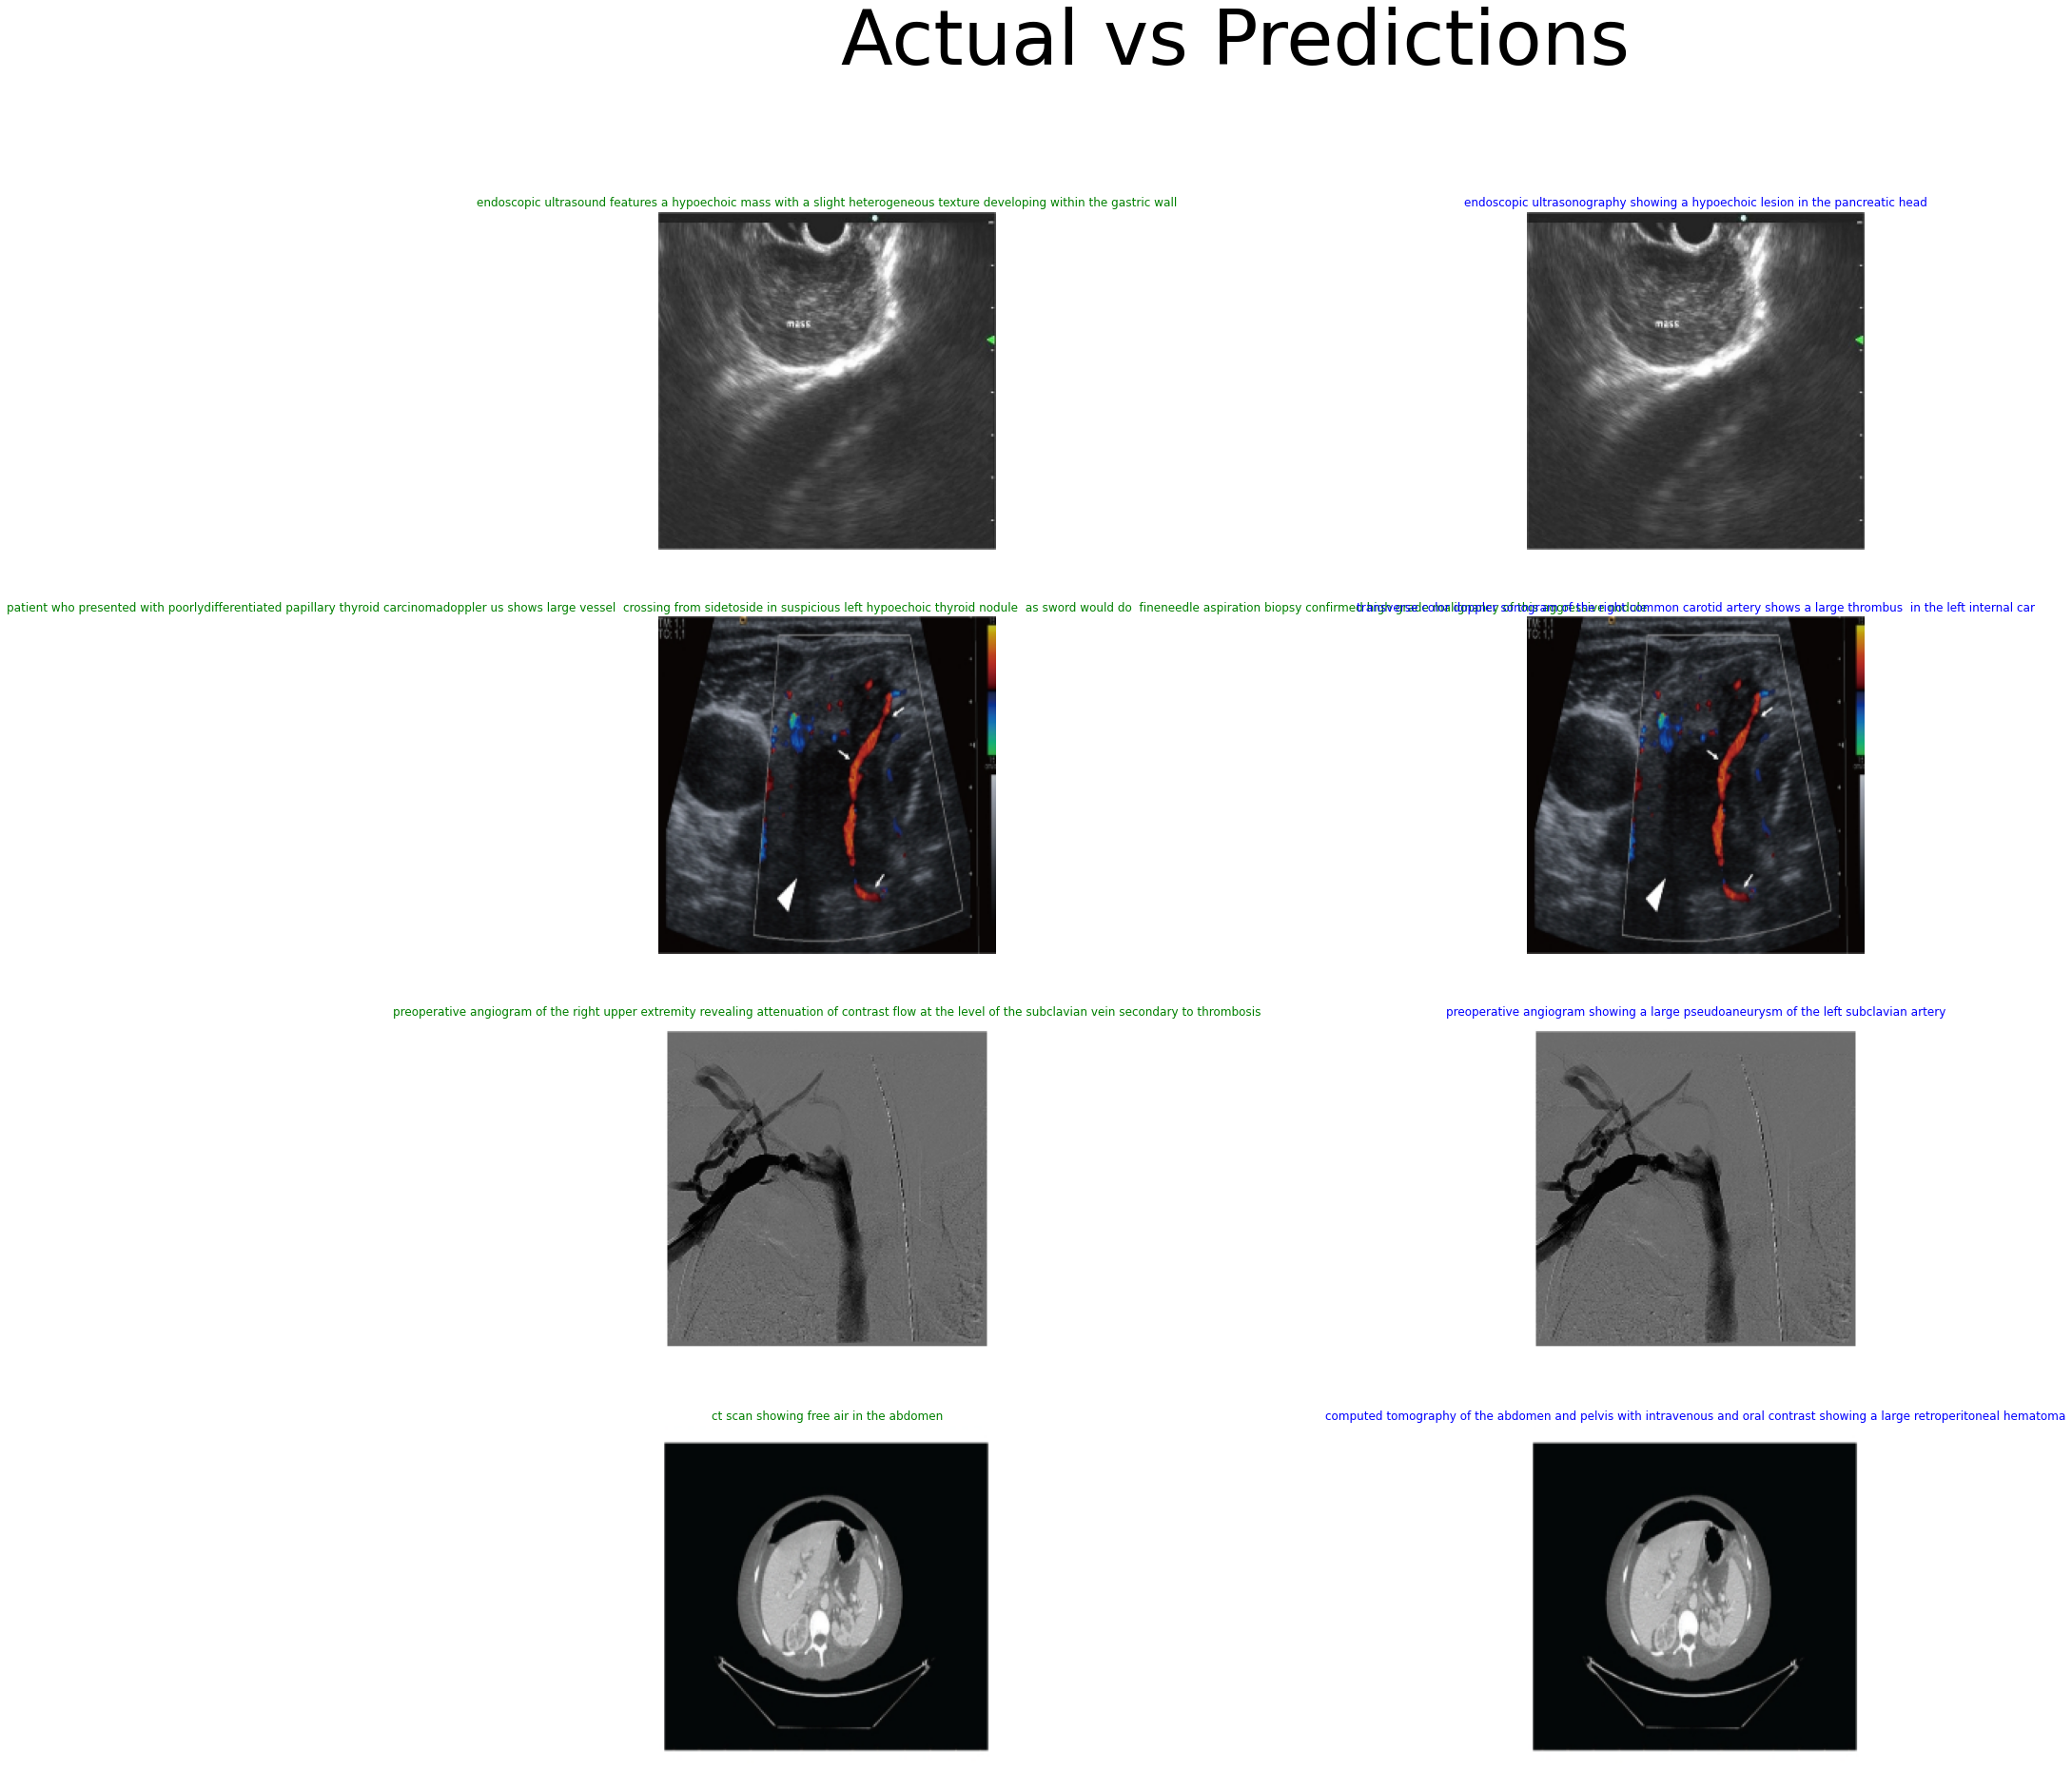

In [ ]:
display_n_images(my_images,im_title=my_titles,im_suptitle=my_predictions,n_rows=4,n_columns=2)

### Bio Bert + VIT

##### Decoder Bio BERT

In [ ]:
# fetch the pretrained Bio_ClinicalBERT tokenizer and mlm model from Hugging face

model = BertForMaskedLM.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', max_len=MAX_LEN)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.examples = []
        
        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = MAX_LEN, truncation=True, padding=True)
            self.examples += [x.input_ids]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i])

In [ ]:
# invoke the CustomDataset for training and validation datasets
train_dataset = CustomDataset(train_df['captions'], tokenizer)
eval_dataset = CustomDataset(validation_df['captions'], tokenizer)

# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

In [ ]:
model_folder = "BIO_BERT"
# Define the training arguments
training_args = TrainingArguments(
    output_dir=model_folder,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    save_steps=8192,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.add_callback(CustomCallback(trainer)) 


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 65419
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10230


***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 65419
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running

TrainOutput(global_step=10230, training_loss=1.210889381863621, metrics={'train_runtime': 9531.3346, 'train_samples_per_second': 68.636, 'train_steps_per_second': 1.073, 'total_flos': 3.581314749871872e+16, 'train_loss': 1.210889381863621, 'epoch': 10.0})

In [ ]:
train_loss_list , train_perplexity_list , val_loss_list , val_perplexity_list = find_metrics_history(trainer)

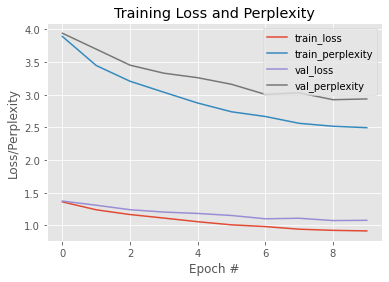

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model along with ther perplexities
N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), train_perplexity_list, label="train_perplexity")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.plot(np.arange(0, N), val_perplexity_list, label="val_perplexity")
plt.title("Training Loss and Perplexity")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Perplexity")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
print('Saving trained model & tokenizer')
print()
trainer.save_model(model_folder)
print()
tokenizer.save_pretrained(model_folder + '_tokenizer')


Saving model checkpoint to BIO_BERT
Configuration saved in BIO_BERT/config.json


Saving trained model & tokenizer



Model weights saved in BIO_BERT/pytorch_model.bin
tokenizer config file saved in BIO_BERT_tokenizer/tokenizer_config.json
Special tokens file saved in BIO_BERT_tokenizer/special_tokens_map.json


('BIO_BERT_tokenizer/tokenizer_config.json',
 'BIO_BERT_tokenizer/special_tokens_map.json',
 'BIO_BERT_tokenizer/vocab.txt',
 'BIO_BERT_tokenizer/added_tokens.json',
 'BIO_BERT_tokenizer/tokenizer.json')

In [ ]:
fill_mask = pipeline(
    "fill-mask",
    model= model_folder,
    tokenizer= model_folder + '_tokenizer')

hardcoded_masked_list = [
{'masked' : '[MASK] appearance in sonography', 'unmasked': 'Hydronephrosis'},
{'masked' :'focal steatosis of the [MASK] parenchyma' , 'unmasked': 'liver'},
{'masked' :'showing the subtrochanteric fracture in the porotic [MASK]' ,  'unmasked': 'bone'},
{'masked' :'computed tomography [MASK] in axial view showing obliteration of the left maxillary sinus'  ,  'unmasked': 'scan'},
{'masked' :'view of giant cell [MASK] of thumb metacarpal preoperatively' ,  'unmasked': 'tumor'},
{'masked' :'[MASK] showing high signals involving the superior sagittal sinus thrombosis on TW1' , 'unmasked': 'MRI'},
{'masked' :'mdct angiography showing the [MASK] of coa in a 1-month-old girl' ,  'unmasked': 'location'},
{'masked' : 'chest radiograph obtained after endoscopic submucosal [MASK] showing left pleural fluid with subsegmental collapse of the left lower lobe', 'unmasked': 'dissection'},
{'masked' :'case 2 tibial [MASK]' ,  'unmasked': 'fracture'},
{'masked' :'computerised tomographic scan chest showing [MASK]' ,  'unmasked': 'tumor'},
{'masked' :'xray of the septic acl reconstructed [MASK]' ,  'unmasked': 'knee'},
{'masked' :'pelvic mri two months after completion of [MASK] therapy reveals no inflammatory change' ,  'unmasked': 'antibiotic'},
{'masked' :'radiograph of the affected [MASK] at 4 weeks' ,  'unmasked': 'shoulder'},
{'masked' :'near infraredautofluorescence image of a normal right [MASK]' ,  'unmasked': 'eye'},
{'masked' :'ap of the right hip following hemiarthroplasty [MASK]' ,  'unmasked': 'surgery'},
{'masked' :'preoperative abdominal ct massive [MASK] hydatid cyst replacing segments iv to viii' ,  'unmasked': 'liver'},
{'masked' :'xray of the septic acl reconstructed [MASK]' ,  'unmasked': 'knee'},
]

In [ ]:
for h in hardcoded_masked_list:
  print('masked sentence : {}'.format(h.get('masked')))
  print('unmasked word : {}'.format(h.get('unmasked')))
  result = fill_mask(h.get('masked'))[0]
  print('predicted word : \"{}\" with maximum score : {}'.format(result.get('token_str'),result.get('score')))
  print()


masked sentence : [MASK] appearance in sonography
unmasked word : Hydronephrosis
predicted word : "normal" with maximum score : 0.4461856186389923

masked sentence : focal steatosis of the [MASK] parenchyma
unmasked word : liver
predicted word : "liver" with maximum score : 0.9624056816101074

masked sentence : showing the subtrochanteric fracture in the porotic [MASK]
unmasked word : bone
predicted word : "area" with maximum score : 0.34262368083000183

masked sentence : computed tomography [MASK] in axial view showing obliteration of the left maxillary sinus
unmasked word : scan
predicted word : "scan" with maximum score : 0.866060197353363

masked sentence : view of giant cell [MASK] of thumb metacarpal preoperatively
unmasked word : tumor
predicted word : "tumor" with maximum score : 0.9578973650932312

masked sentence : [MASK] showing high signals involving the superior sagittal sinus thrombosis on TW1
unmasked word : MRI
predicted word : "image" with maximum score : 0.32701238989

##### Decoder Bio Bert + Encoder ViT

In [ ]:
# fetch the pretrained BIO_BERT tokenizer and feature extractor from VIT


model_folder = "BIO_BERT"
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained(model_folder + '_tokenizer',max_len=MAX_LEN)

In [ ]:
# invoke the ROCO_Dataset for training and validation datasets
train_dataset = ROCO_Dataset(df=train_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = ROCO_Dataset(df=validation_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

In [ ]:
# define VisionEncoderDecoderModel with the respective encoder and decoder

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k",model_folder, tie_encoder_decoder=True)

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size


# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 30 # modified
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)


# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 65419
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 10225


***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-2048
Configuration saved in VIT_Captioning/checkpoint-2048/config.json
Model weights saved in VIT_Captioning/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-2048/preprocessor_config.json


***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-4096
Configuration saved in VIT_Captioning/checkpoint-4096/config.json
Model weights saved in VIT_Captioning/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_Captioning/checkpoint-2048] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-6144
Configuration saved in VIT_Captioning/checkpoint-6144/config.json
Model weights saved in VIT_Captioning/checkpoint-6144/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-6144/preprocessor_config.json
Deleting older checkpoint [VIT_Captioning/checkpoint-4096] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-

TrainOutput(global_step=10225, training_loss=2.355119861705379, metrics={'train_runtime': 15783.9377, 'train_samples_per_second': 20.723, 'train_steps_per_second': 0.648, 'total_flos': 5.921232999688581e+19, 'train_loss': 2.355119861705379, 'epoch': 5.0})

In [ ]:
train_loss_list , train_rouge1_list , train_rouge2_list ,  val_loss_list , val_rouge1_list , val_rouge2_list = find_metrics_rouge_history(trainer)

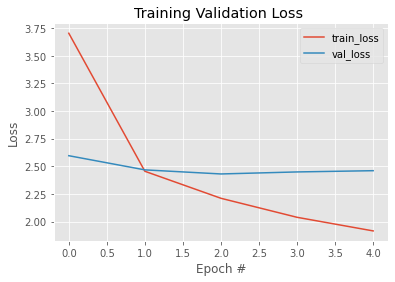

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model 
N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.title("Training Validation Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

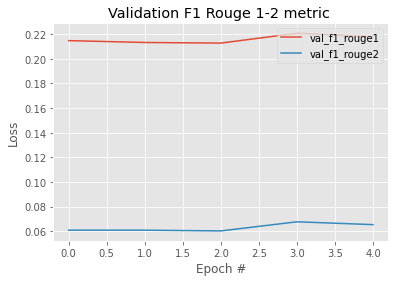

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation rouge1 metrics
N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), val_rouge1_list, label="val_f1_rouge1")
plt.plot(np.arange(0, N), val_rouge2_list, label="val_f1_rouge2")
plt.title("Validation F1 Rouge 1-2 metric ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
trainer.save_model('VIT_Captioning'+'_'+model_folder)

In [ ]:
load_model = VisionEncoderDecoderModel.from_pretrained('VIT_Captioning'+'_'+model_folder)

In [ ]:
# display images along with the original captions as well as the predicted captions
my_images , my_titles , my_predictions = display_score_images(df=test_df,my_model=load_model,n_limit=4)

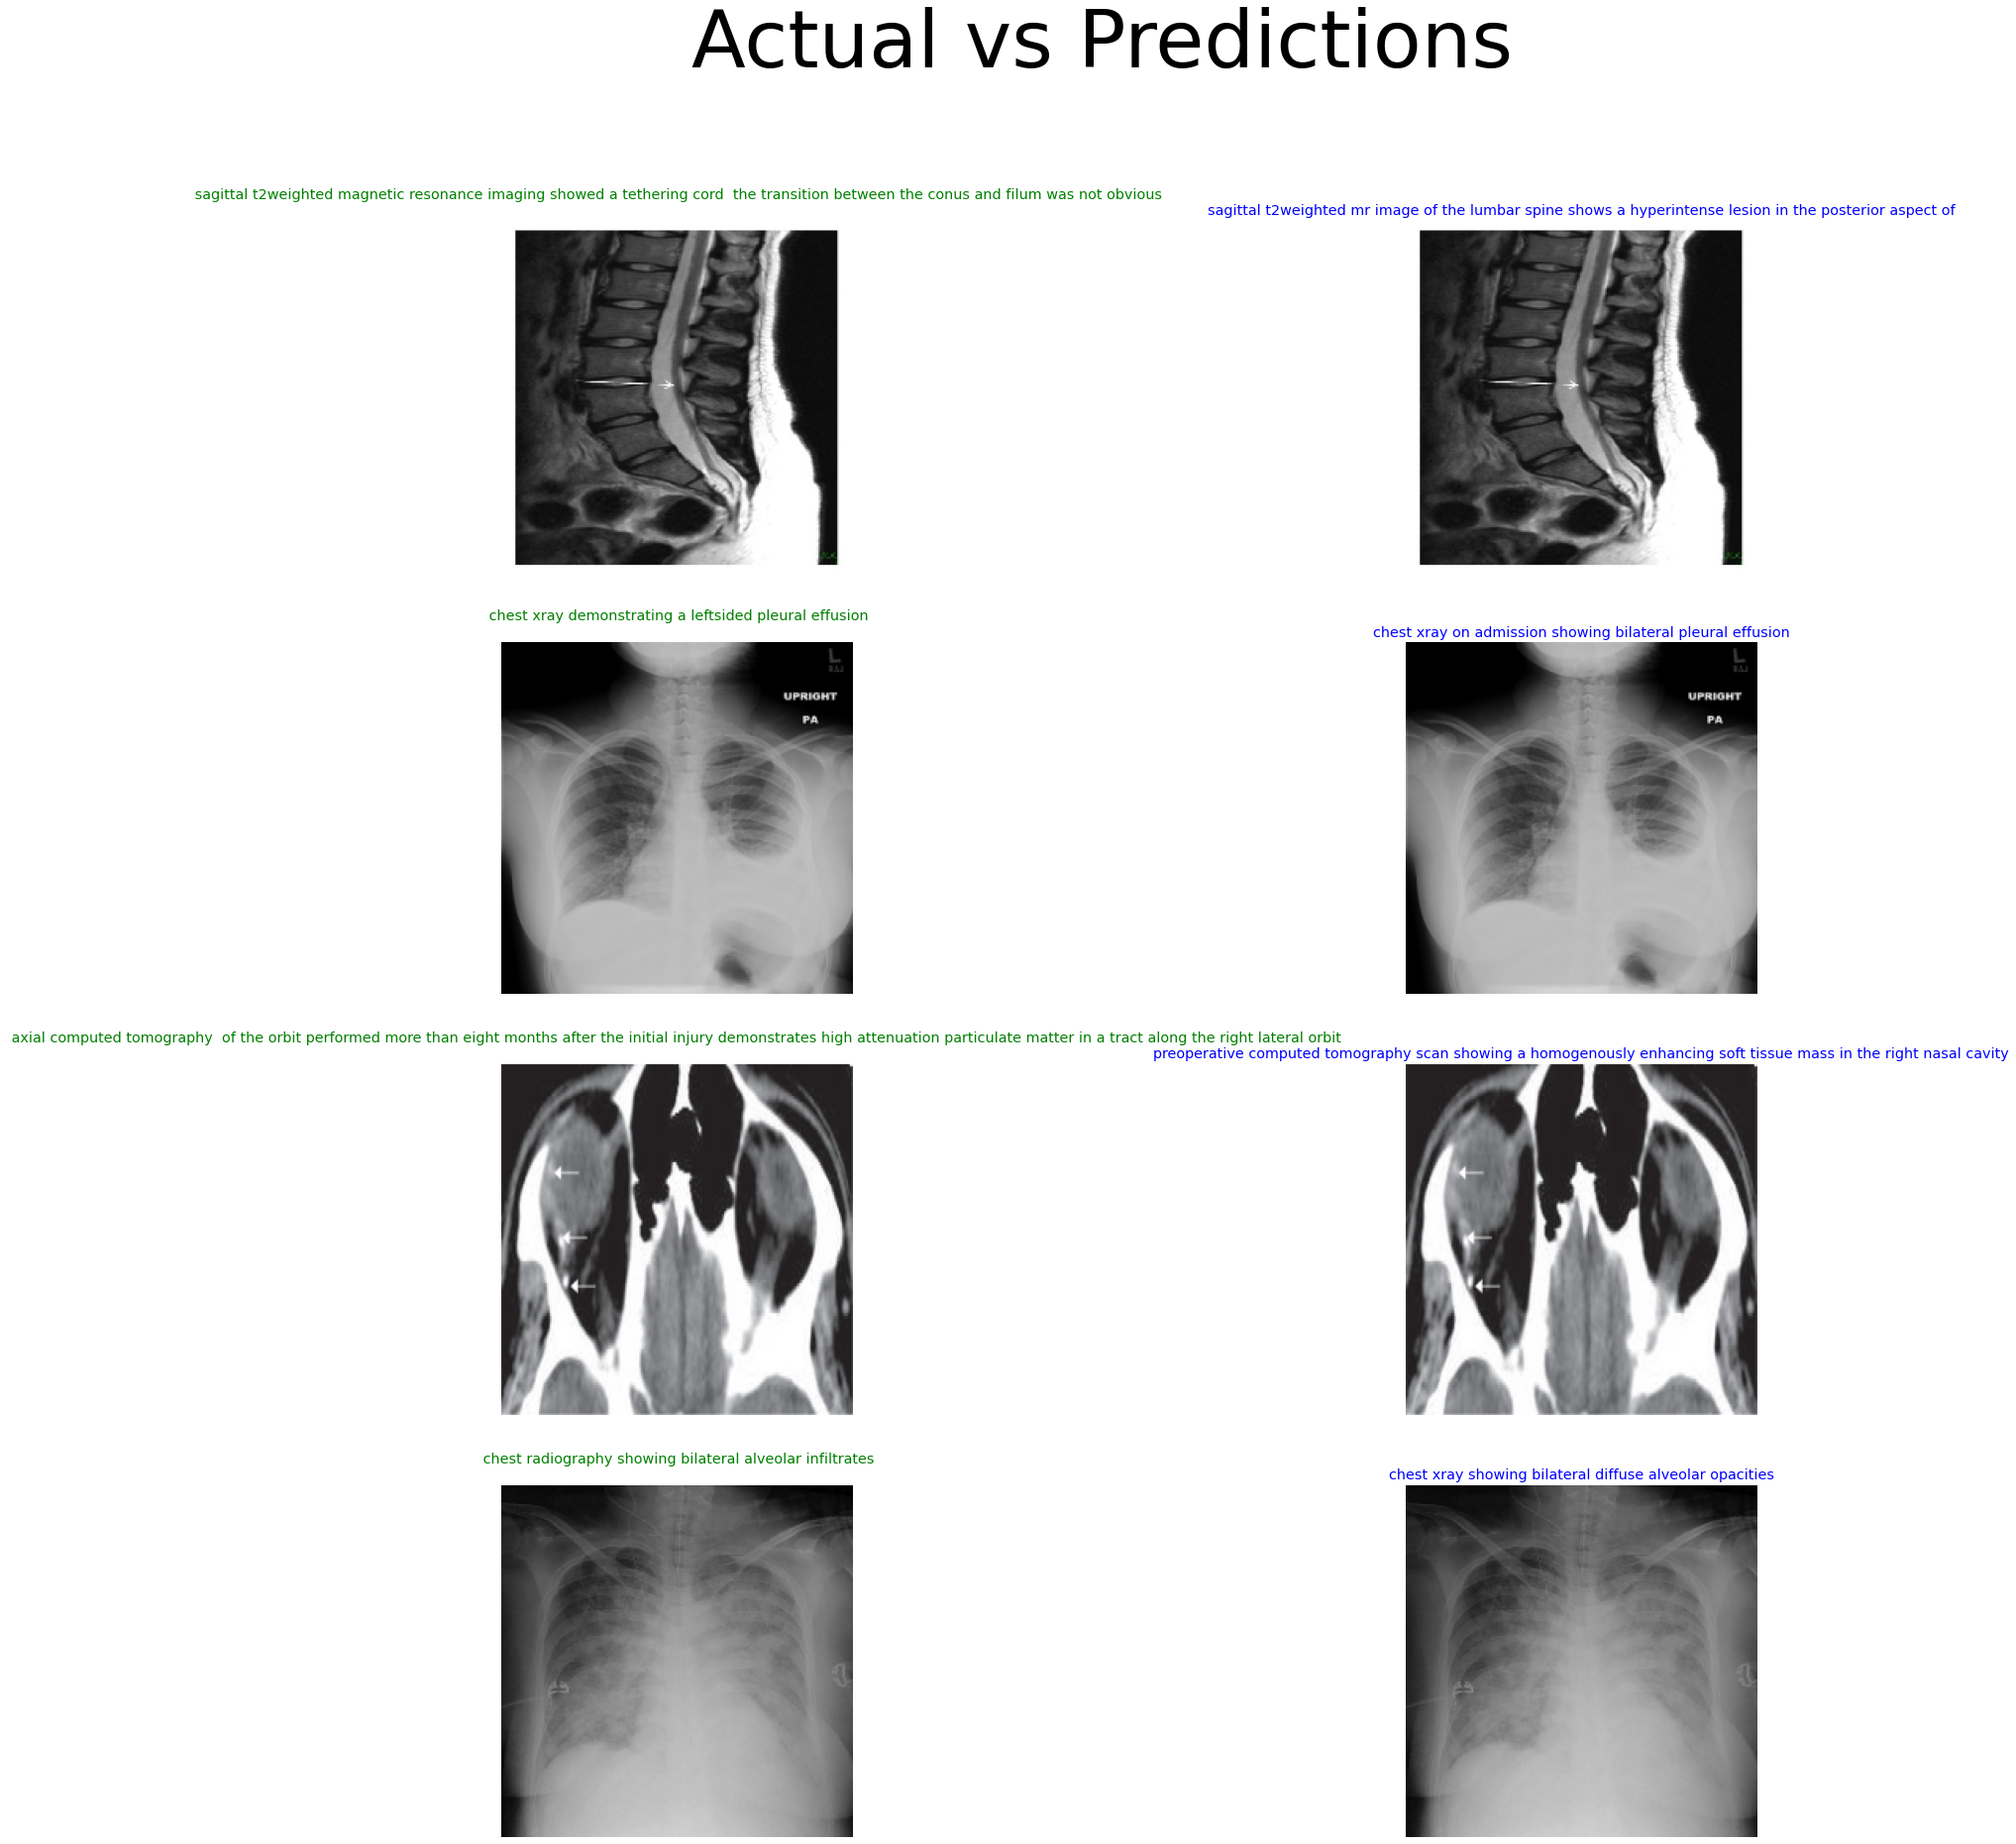

In [ ]:
display_n_images(my_images,im_title=my_titles,im_suptitle=my_predictions,n_rows=4,n_columns=2)

In [ ]:
# display images along with the original captions as well as the predicted captions
my_images , my_titles , my_predictions = display_score_images(df=test_df,my_model=load_model,n_limit=4)

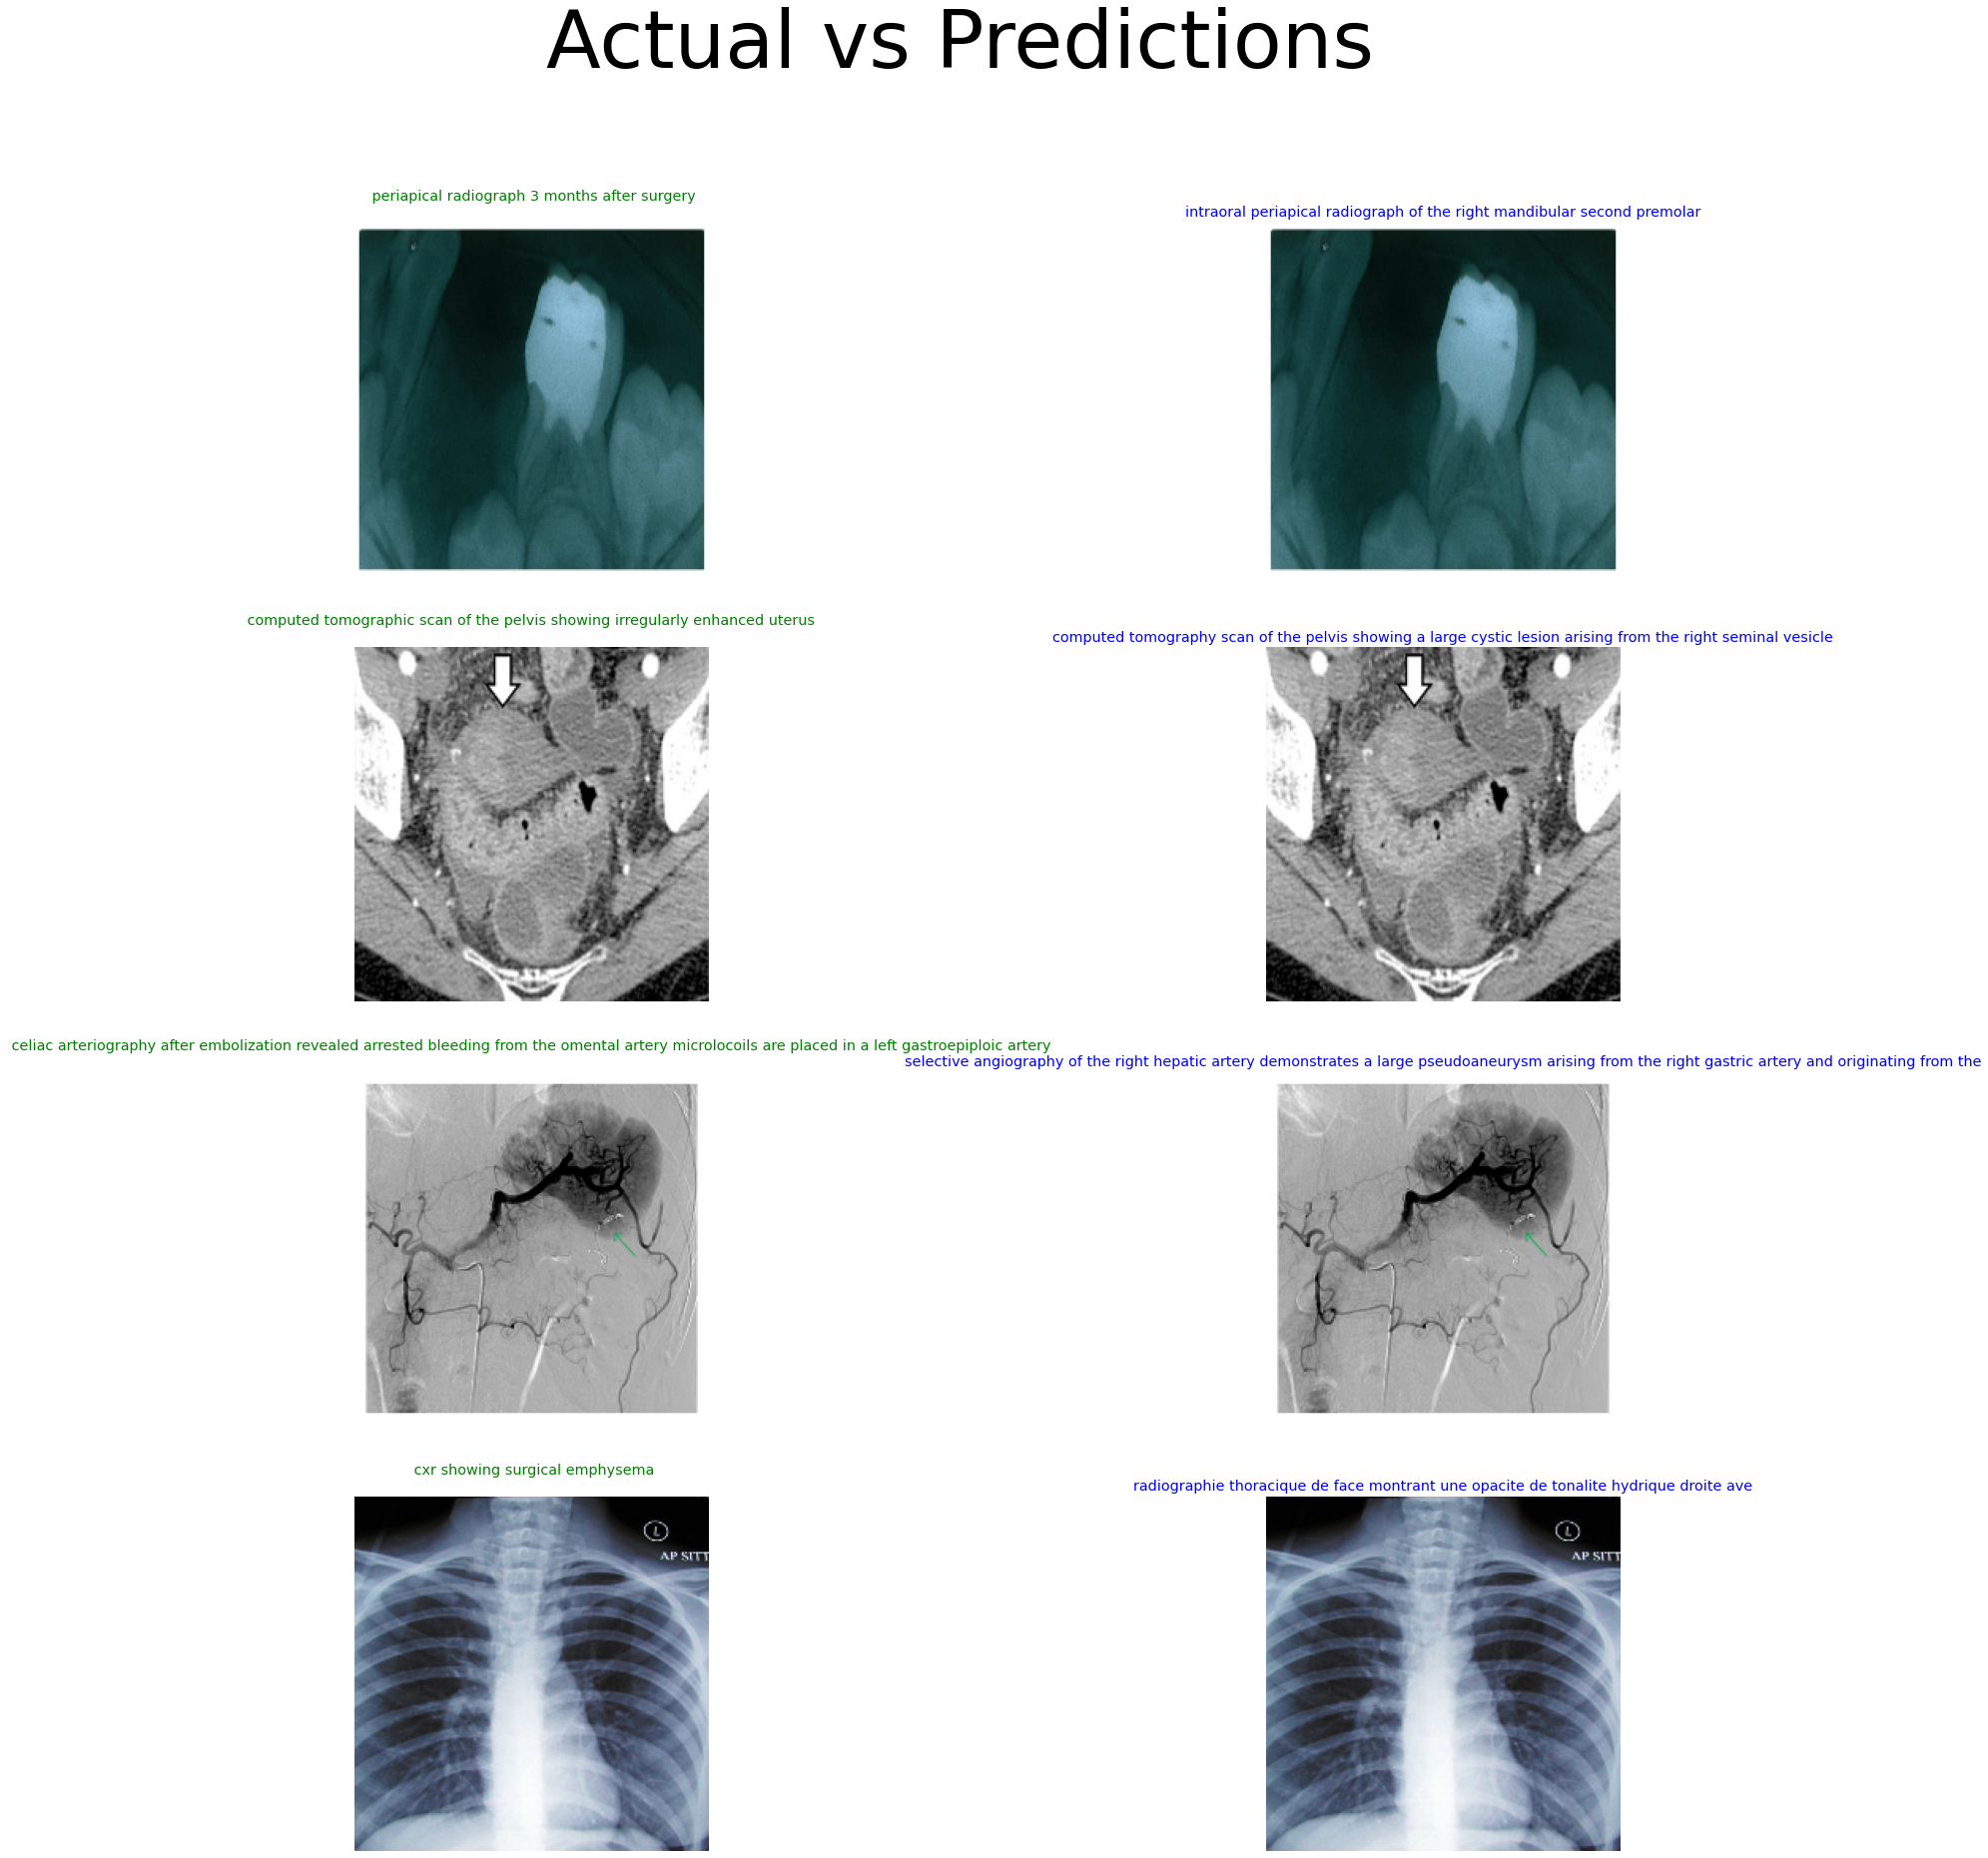

In [ ]:
display_n_images(my_images,im_title=my_titles,im_suptitle=my_predictions,n_rows=4,n_columns=2)

### GPT2 + VIT

##### Decoder GPT2 

In [ ]:
# Create default config
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
# Load pretrained gpt2
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
# load pretrained gpt2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<sos>', eos_token='<eos>', pad_token='<pad>')

model.resize_token_embeddings(len(tokenizer))

# Create device
device = torch.device("cuda")
model.cuda()


optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005)
model = model.to(device)

In [ ]:
class RocDataset(Dataset):

  def __init__(self, sentences, tokenizer, gpt2_type="gpt2", max_length=MAX_LEN):

    self.tokenizer = tokenizer 
    self.input_ids = []
    self.attn_masks = []

    for sentence in sentences:      
      encodings = tokenize_seq(sentence,tokenizer,max_length)
            
      self.input_ids.append(torch.tensor(encodings['input_ids']))
      self.attn_masks.append(torch.tensor(encodings['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]   

    

In [ ]:
# invoke the RocDataset and a Dataloader for training and validation datasets

train_dataset = RocDataset(train_df['captions'].tolist(), tokenizer, max_length=MAX_LEN)
val_dataset = RocDataset(validation_df['captions'].tolist(), tokenizer, max_length=MAX_LEN)
train_dataloader = DataLoader(train_dataset,  batch_size = 32)
validation_dataloader = DataLoader(val_dataset, batch_size = 32 )

In [ ]:
#call model with a batch of input
def process_one_batch(batch):
  b_input_ids = batch[0].to(device)
  b_labels = batch[0].to(device)
  b_masks = batch[1].to(device)
  outputs  = model(b_input_ids,  attention_mask = b_masks,labels=b_labels)
  return outputs

#do one epoch for training
def train_epochs(number_of_e):
  avg_val_loss_list = []
  avg_train_loss_list = []
  model.train()

  for e in range(1,number_of_e+1):
    t0 = time.time()
    total_train_loss = 0
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    # for step, batch in enumerate(train_dataloader):
          
          model.zero_grad()        
          outputs = process_one_batch( batch)
          loss = outputs[0]  
          batch_loss = loss.item()
          total_train_loss += batch_loss

          loss.backward()
          optimizer.step()

          
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_loss_list.append(avg_train_loss)  
    print("Training loss : ",avg_train_loss)  
    elapsed_time = format_time(time.time() - t0)
    print("Time for Training epoch {} : ".format(e),elapsed_time)
    avg_val_loss_list.append(eval_epoch())
  return avg_train_loss_list , avg_val_loss_list

#do one epoch for eval
def eval_epoch():
  t0 = time.time()
  total_eval_loss = 0
  nb_eval_steps = 0
  # Evaluate data for one epoch
  for step, batch in tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
            
        
    with torch.no_grad():        
      outputs = process_one_batch( batch)
      loss = outputs[0]              
      batch_loss = loss.item()
      total_eval_loss += batch_loss         

  avg_val_loss = total_eval_loss / len(validation_dataloader)
  print("Validation loss",avg_val_loss) 
  elapsed_time = format_time(time.time() - t0)
  print("Time for Evaluation epoch : ",elapsed_time)
  return avg_val_loss

In [ ]:
avg_train_loss_list , avg_val_loss_list = train_epochs(number_of_e = TRAIN_EPOCHS)

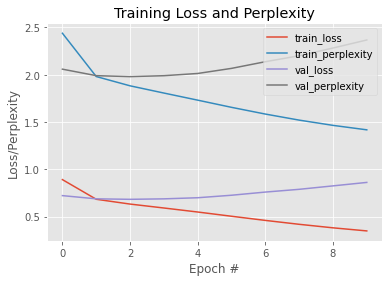

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model along with ther perplexities

N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), avg_train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), train_perplexity_list, label="train_perplexity")
plt.plot(np.arange(0, N), avg_val_loss_list, label="val_loss")
plt.plot(np.arange(0, N), val_perplexity_list, label="val_perplexity")
plt.title("Training Loss and Perplexity")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Perplexity")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
model_folder = 'GPT2'

model.save_pretrained(model_folder)
print()
tokenizer.save_pretrained(model_folder + '_tokenizer')

In [ ]:
def eval_keywords(keywords,my_model,my_tokenizer):
  my_model.eval()
  for keyword in keywords:
    input_seq = "<sos> " + keyword
    generated = torch.tensor(my_tokenizer.encode(input_seq)).unsqueeze(0)
    # generated = generated.to(device)
    sample_outputs = my_model.generate(
                                generated, 
                                pad_token_id=tokenizer.eos_token_id,
                                do_sample=True,   
                                top_k=30, 
                                max_length = 50,
                                top_p=0.90, 
                                num_return_sequences=2
                                )
    for i, sample_output in enumerate(sample_outputs):
      print("{}: {}".format(i, my_tokenizer.decode(sample_output, skip_special_tokens=True)))



In [ ]:
# evaluate the GPT2 decoder
tokenizer = GPT2Tokenizer.from_pretrained(model_folder + '_tokenizer',max_len=MAX_LEN)
model = GPT2LMHeadModel.from_pretrained(model_folder)


In [ ]:
keywords = ["panoramic radiograph","the patient","tumor","liver","ct","angiography","chest xray","scan"]
eval_keywords(keywords=keywords,my_model= model, my_tokenizer=tokenizer)

0:  panoramic radiograph obtained after trauma showing a wellcircumscribed uniloculer radiolucent lesion involving right maxilla
1:  panoramic radiograph of patient
0:  the patient underwent radiotherapy and presented a lower left third molar tooth fracture
1:  the patient underwent a folfirino spin echo t2weighted spin echo mr documenting spinous process compression
0:  tumor and didelphys uterus 2nd week of pregnancy
1:  tumor mass of the left parotid gland
0:  liver cystic teratoma 
1:  liver cyst on ct scan
0:  ct scan showing the expansion of the mandibular buccal and lingual cortical plates with no periosteal reaction or soft tissue edema
1:  ct scan showing the tumor in the nasal septum 
0:  angiography showing a large aneurysm arising from the right basal and anterior circulation of the right lower lobe
1:  angiography of the right kidney showing the presence of the collateral veins in the lower pole of the left kidney
0:  chest xray showing right hilar prominence
1:  chest xra

##### Decoder GPT2 + Encoder ViT

In [ ]:
# fetch the pretrained GPT2 tokenizer and feature extractor from VIT

model_folder = "GPT2"

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = GPT2Tokenizer.from_pretrained(model_folder + '_tokenizer',max_len=MAX_LEN)

In [ ]:
# invoke the ROCO_Dataset for training and validation datasets
train_dataset = ROCO_Dataset(df=train_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = ROCO_Dataset(df=validation_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k",model_folder, tie_encoder_decoder=True)

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size


# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 30 # modified
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    num_train_epochs = TRAIN_EPOCHS, 
    overwrite_output_dir=True,
    save_total_limit=1,
)


# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [ ]:
# train the model
trainer.train()

***** Running training *****
  Num examples = 65419
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 10225


***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-2048
Configuration saved in VIT_Captioning/checkpoint-2048/config.json
Model weights saved in VIT_Captioning/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-2048/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-4096
Configuration saved in VIT_Captioning/checkpoint-4096/config.json
Model weights saved in VIT_Captioning/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_Captioning/checkpoint-2048] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-6144
Configuration saved in VIT_Captioning/checkpoint-6144/config.json
Model weights sav

TrainOutput(global_step=10225, training_loss=1.190829833387454, metrics={'train_runtime': 19386.7065, 'train_samples_per_second': 16.872, 'train_steps_per_second': 0.527, 'total_flos': 5.902883646593827e+19, 'train_loss': 1.190829833387454, 'epoch': 5.0})

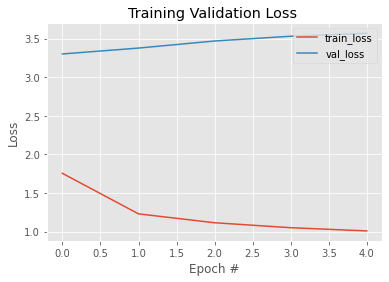

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model 
N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.title("Training Validation Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

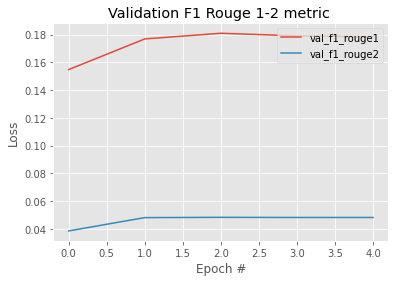

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation rouge1 metrics

N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), val_rouge1_list, label="val_f1_rouge1")
plt.plot(np.arange(0, N), val_rouge2_list, label="val_f1_rouge2")
plt.title("Validation F1 Rouge 1-2 metric ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
trainer.save_model('VIT_Captioning'+'_'+model_folder)

In [ ]:
load_model = VisionEncoderDecoderModel.from_pretrained('VIT_Captioning'+'_'+model_folder)

In [ ]:
# display images along with the original captions as well as the predicted captions

my_images , my_titles , my_predictions = display_score_images(df=test_df,my_model=load_model,n_limit=4)

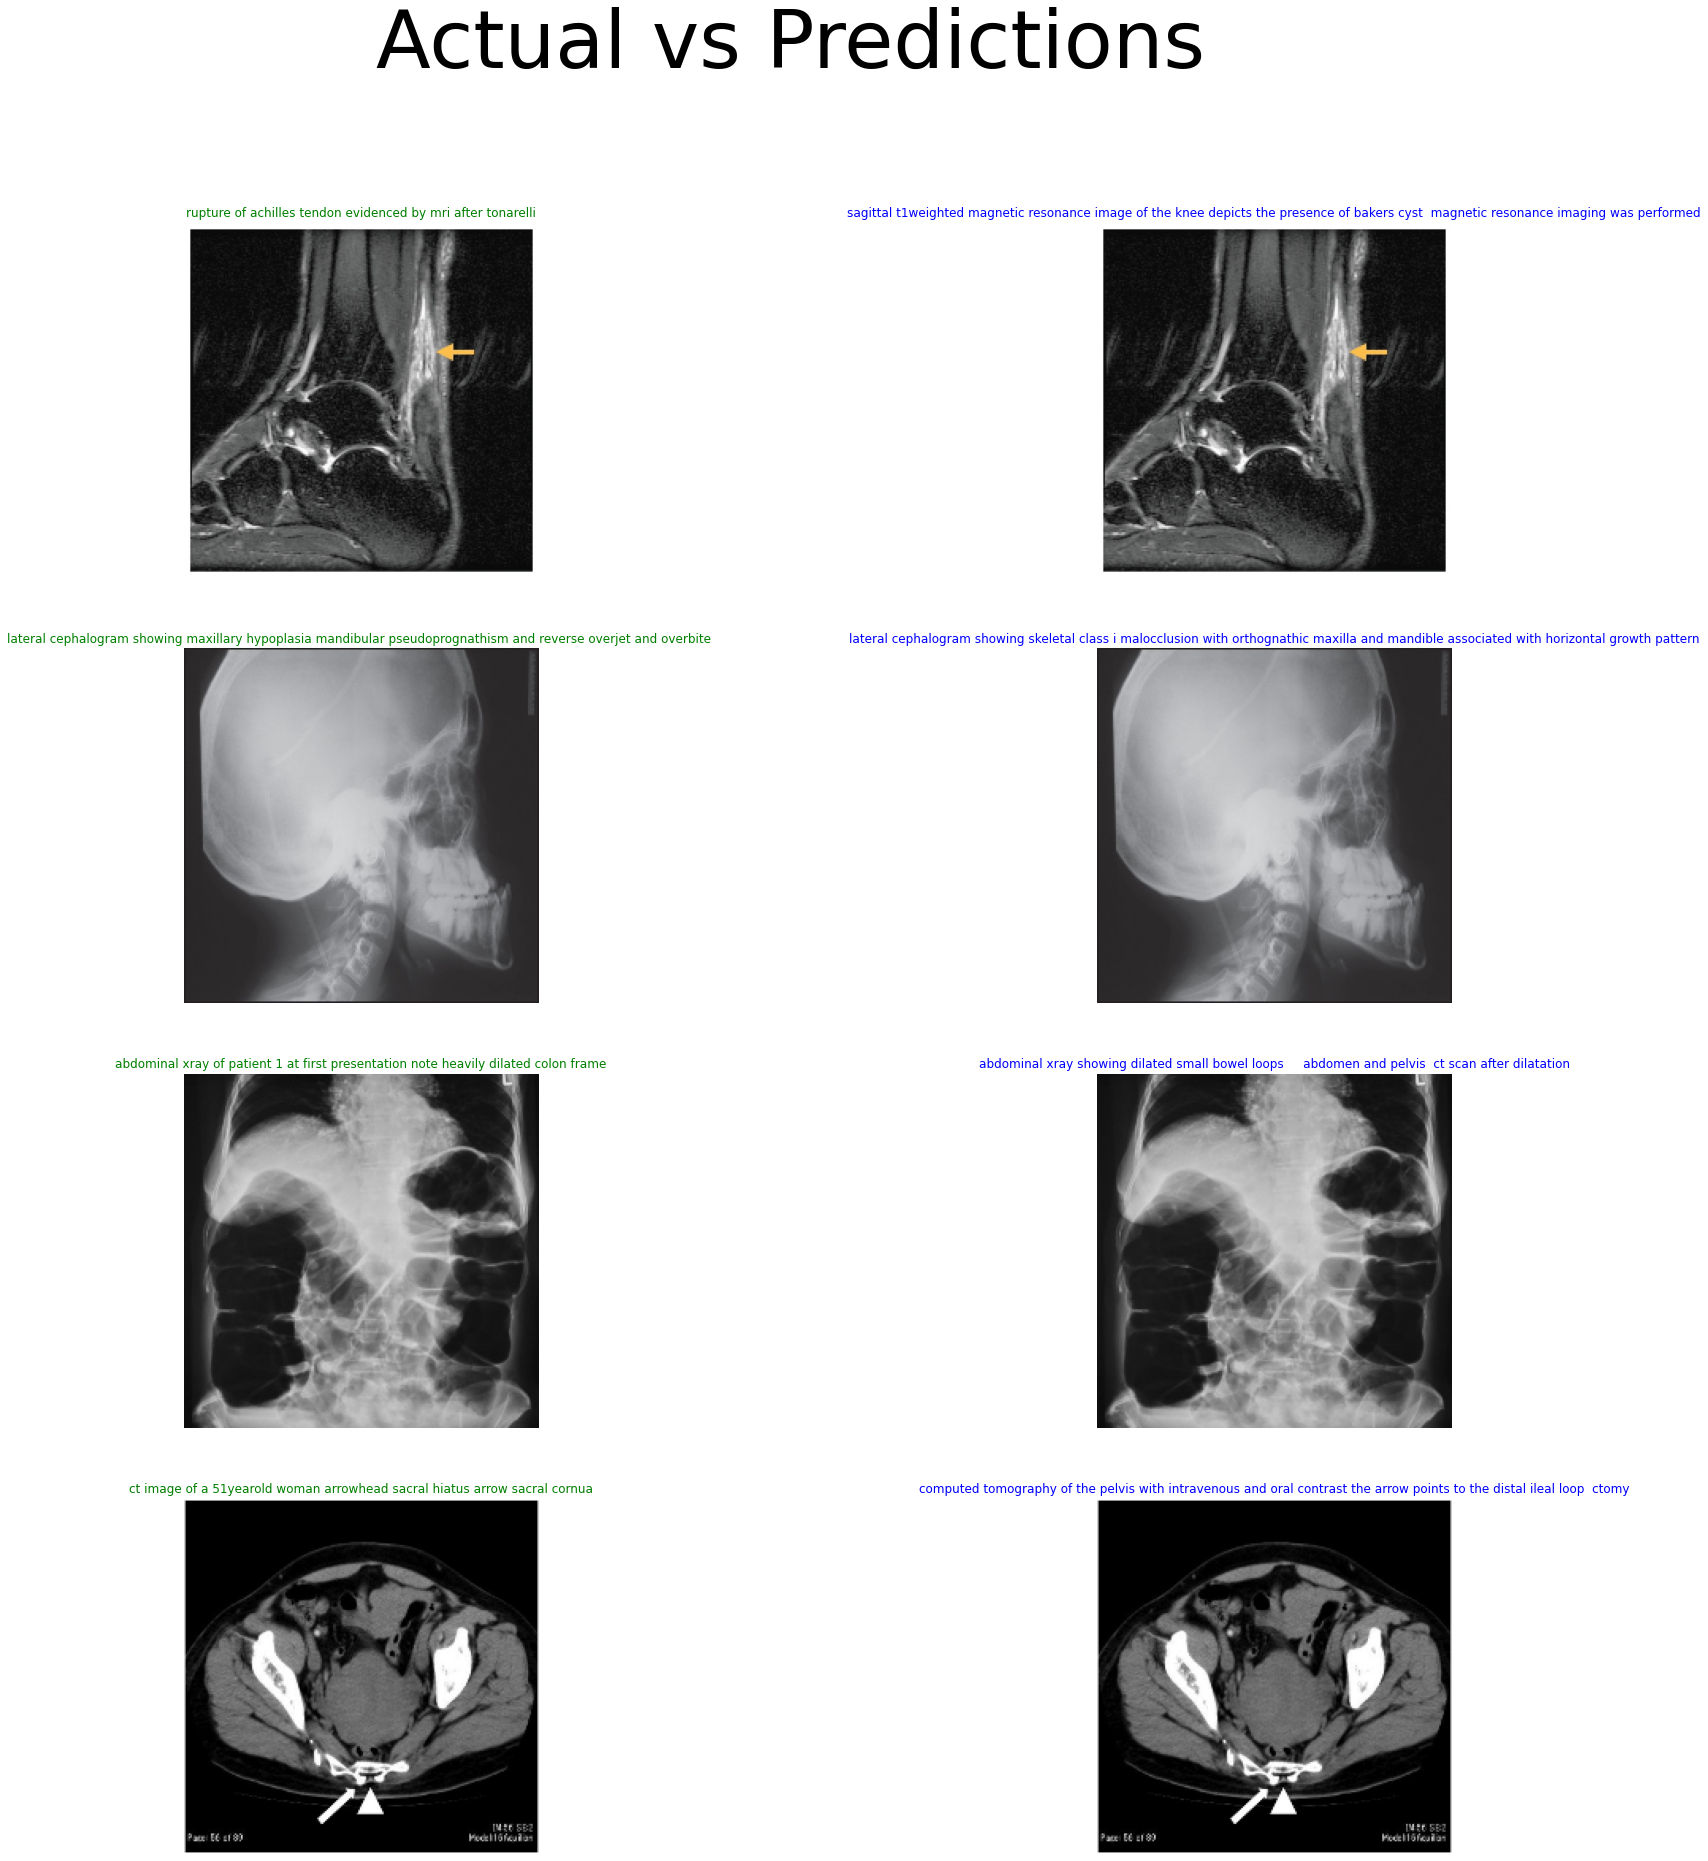

In [ ]:
display_n_images(my_images,im_title=my_titles,im_suptitle=my_predictions,n_rows=4,n_columns=2)

### Greek Bert + VIT

##### Adjust GR data

In [ ]:
# Load from goodle drive the json files 
# with all the greek translations
# and attach them to train & validation dataframe 

with open('valid_data.json', 'r') as openfile:
    # Reading from json file
    valid_gr_list = json.load(openfile)

with open('train_data.json', 'r') as openfile:
    # Reading from json file
    train_gr_list = json.load(openfile)

In [ ]:
train_df['captions_gr'] = train_gr_list
validation_df['captions_gr'] = valid_gr_list

validation_df = cleansing_col(validation_df)
train_df = cleansing_col(train_df)

In [ ]:
train_df.head(5)

images  \
0  /content/roco/all_data/train/radiology/images/...   
1  /content/roco/all_data/train/radiology/images/...   
2  /content/roco/all_data/train/radiology/images/...   
3  /content/roco/all_data/train/radiology/images/...   
4  /content/roco/all_data/train/radiology/images/...   

                                            captions  \
0   Computed tomography scan in axial view showin...   
1   Bacterial contamination occurred after comple...   
2   The patient had residual paralysis of the han...   
3    Panoramic radiograph after immediate loading.\n   
4   Plain abdomen x-ray: Multiple air levels at t...   

                                         captions_gr  
0  υπολογισμενη τομογραφια σε αξονικη αποψη που δ...  
1  η βακτηριακη μολυνση πραγματοποιηθηκε μετα την...  
2  ο ασθενης ειχε υπολειμματικη παραλυση του χερι...  
3     πανοραμικη ακτινογραφια μετα την αμεση φορτωση  
4  απλη κοιλιακη χωρα χ  ray πολλαπλα επιπεδα αερ...

##### Data Visualizations

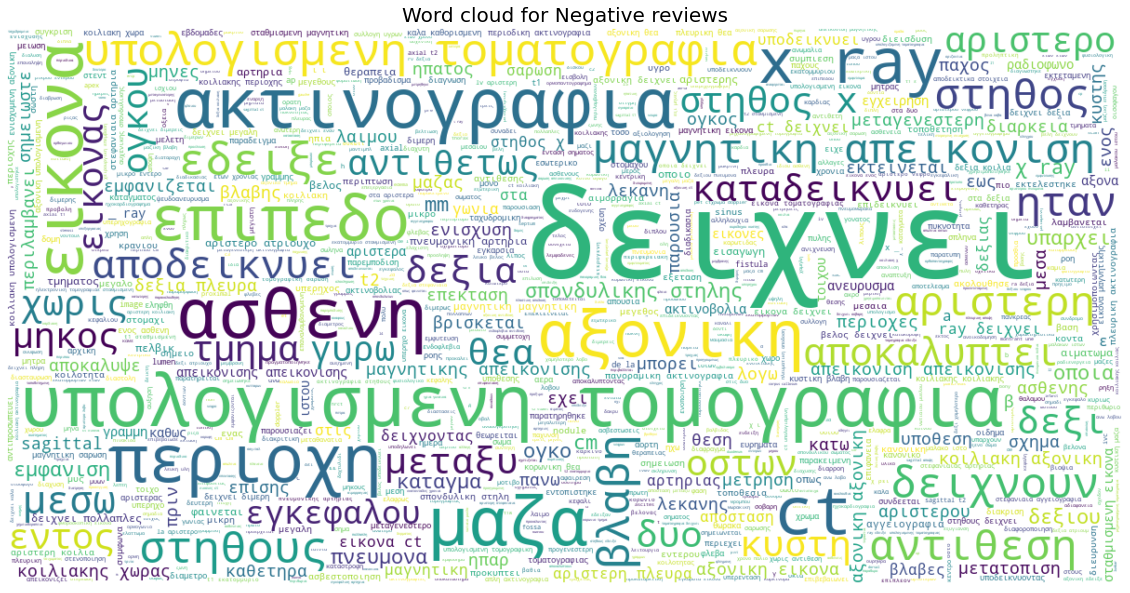

In [ ]:
# generate a wordcloud with all the top greek words
new_stopwords = create_gr_stopwords(stopwords)

uni_data = train_df['captions_gr']
uni_data_string = ' '.join(uni_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="white",stopwords=new_stopwords).generate(uni_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Negative reviews',fontsize = 20)
plt.show()

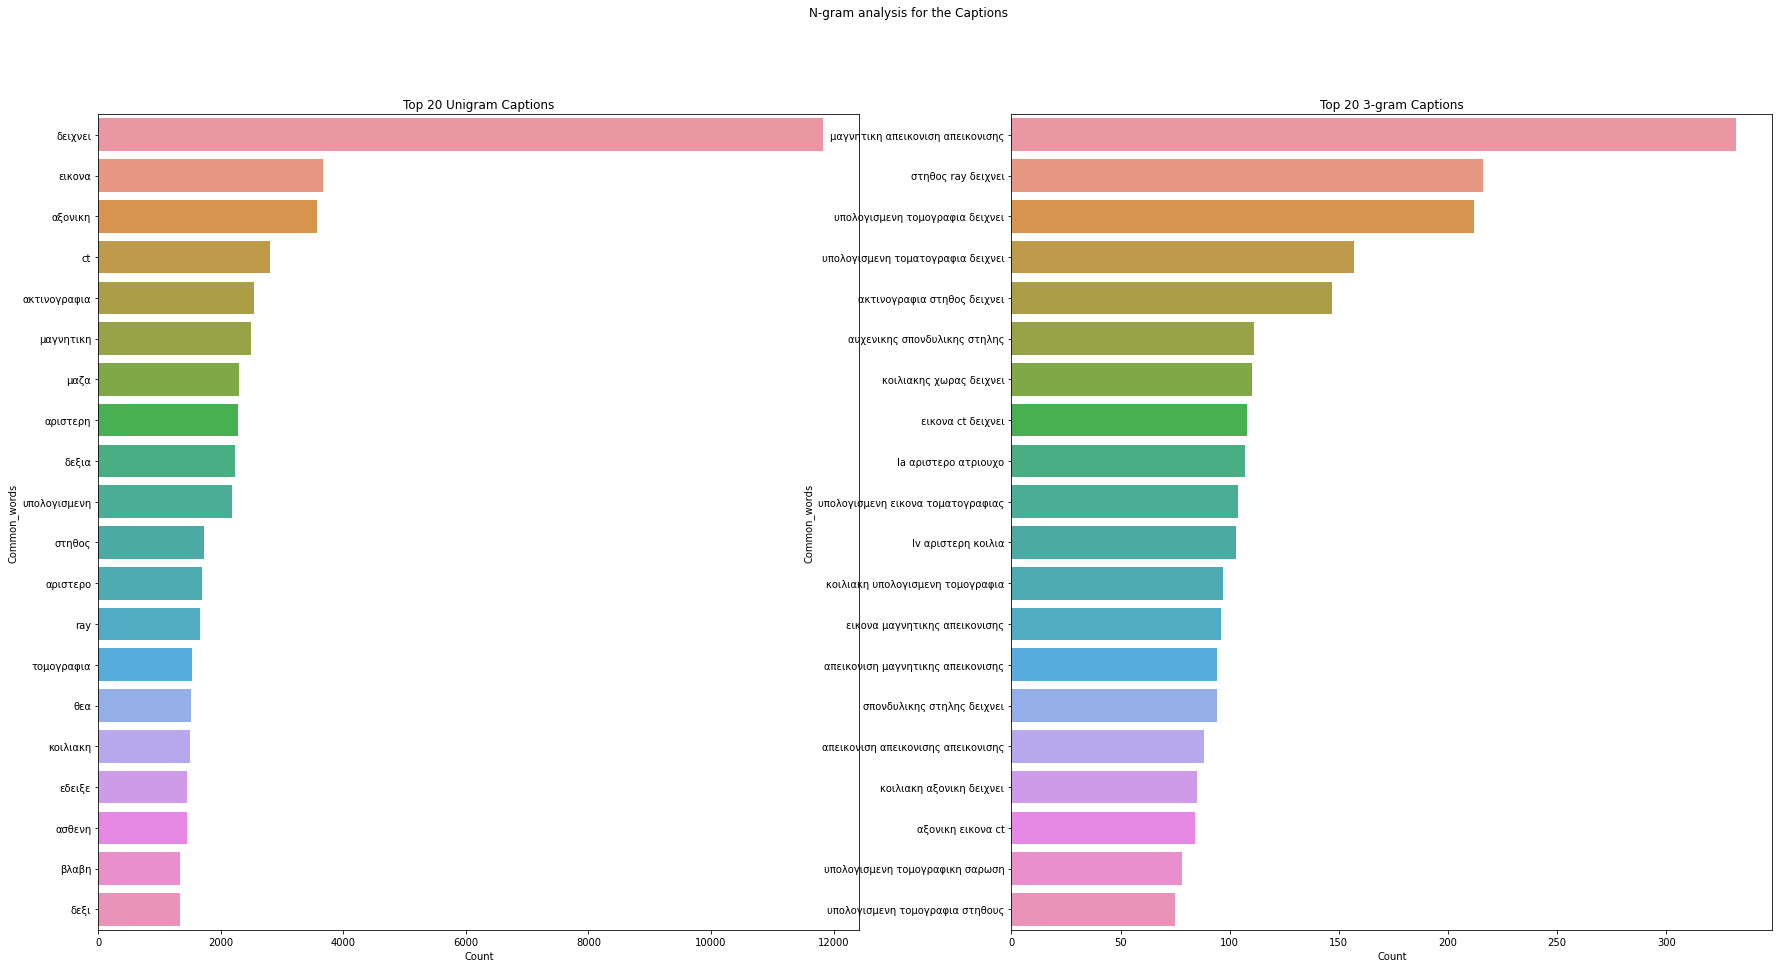

In [ ]:
# visualize a top n gram  based on the greek captions

uni_data = train_df['captions_gr']
uni_data = uni_data.to_frame()
uni_data['captions_gr'] = uni_data['captions_gr'].apply(lambda x: ' '.join([word for word in x.split() if word not in (new_stopwords)]))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))

bi_negative = get_ngrams(uni_data['captions_gr'],20,1)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax=ax1)

bi_neutral = get_ngrams(uni_data['captions_gr'],20,3)
bi_neutral = dict(bi_neutral)
temp = pd.DataFrame(list(bi_neutral.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax=ax2)


ax1.set_title('Top 20 Unigram Captions')
ax2.set_title('Top 20 3-gram Captions')
fig.suptitle('N-gram analysis for the Captions')
plt.show()

##### Decoder Greek Bert

In [ ]:
# fetch the pretrained Greek Bert tokenizer and mlm model from Hugging face

model = BertForMaskedLM.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/bert-base-greek-uncased-v1', max_len=MAX_LEN)

In [ ]:
# invoke the CustomDataset for training and validation datasets


train_dataset = CustomDataset(train_df['captions_gr'], tokenizer)
eval_dataset = CustomDataset(validation_df['captions_gr'], tokenizer)
# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

In [ ]:
model_folder = "Greek_BERT"
# Define the training arguments
training_args = TrainingArguments(
    output_dir=model_folder,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=10,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    save_steps=8192,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
# add callback to the trainer
trainer.add_callback(CustomCallback(trainer)) 


In [ ]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 31983
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 5000


***** Running Evaluation *****
  Num examples = 31983
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 31983
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 31983
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 31983
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 31983
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 31983
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running Evaluation *****
  Num examples = 31983
  Batch size = 5
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 5
***** Running

TrainOutput(global_step=5000, training_loss=2.2186902099609376, metrics={'train_runtime': 4544.0514, 'train_samples_per_second': 70.384, 'train_steps_per_second': 1.1, 'total_flos': 1.5903073710249984e+16, 'train_loss': 2.2186902099609376, 'epoch': 10.0})

In [ ]:
train_loss_list , train_perplexity_list , val_loss_list , val_perplexity_list = find_metrics_history(trainer)

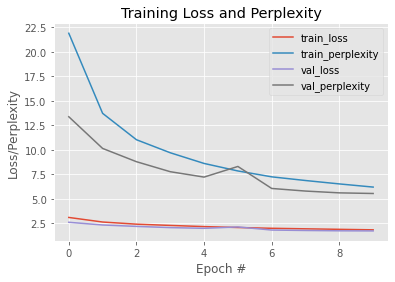

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model along with ther perplexities

N= 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), train_perplexity_list, label="train_perplexity")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.plot(np.arange(0, N), val_perplexity_list, label="val_perplexity")
plt.title("Training Loss and Perplexity")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Perplexity")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
print('Saving trained model & tokenizer')
print()
trainer.save_model(model_folder)
print()
tokenizer.save_pretrained(model_folder + '_tokenizer')


Saving model checkpoint to Greek_BERT
Configuration saved in Greek_BERT/config.json


Saving trained model & tokenizer



Model weights saved in Greek_BERT/pytorch_model.bin
tokenizer config file saved in Greek_BERT_tokenizer/tokenizer_config.json
Special tokens file saved in Greek_BERT_tokenizer/special_tokens_map.json


('Greek_BERT_tokenizer/tokenizer_config.json',
 'Greek_BERT_tokenizer/special_tokens_map.json',
 'Greek_BERT_tokenizer/vocab.txt',
 'Greek_BERT_tokenizer/added_tokens.json',
 'Greek_BERT_tokenizer/tokenizer.json')

In [ ]:
fill_mask = pipeline(
    "fill-mask",
    model= model_folder,
    tokenizer= model_folder + '_tokenizer')

hardcoded_masked_list = [
{'masked' : 'υπολογισμενη [MASK] σε αξονικη αποψη που δειχνει εξαλειψη του αριστερου μεγιστου αμινου', 'unmasked': 'τομογραφια'},
{'masked' :'η σπονδυλικη [MASK] ct δειχνει μαζα σε επιπεδο c3 με σημαδεμενη καταστροφη οσων' , 'unmasked': 'στηλη'},
{'masked' :'μεταθανατια πανοραμικη ακτινογραφια μετα το [MASK] το κοστοχονδρικο μοσχευμα προσαρμοσμενο στην αριστερη περιοχη κοντυλ και εξασφαλισμενο' ,  'unmasked': 'χειρουργειο'},
{'masked' :'στην αριστερη μανδιβουαλικη ramus κατα πεντε ποδηλατικες [MASK] για ακαμπτη εσωτερικη στερεωση'  ,  'unmasked': 'βιδες'},
{'masked' :'αλιευματα των [MASK] με νημα ραμματος 50 non ραμματος και την ανατομη τους κοντα στην εισαγωγη προσθεση ματιων αποτελουμενη απο μεθακρυλικο πολυμεθυλιο καλυμμενη με κελυφος τερεφθαλικου πολυαιθυλενιου' ,  'unmasked': 'μυων'},
{'masked' :'μεταθανατια πλευρικη [MASK] ενος γυναικειου ασθενη τρεις μηνες μετα την εγχειρηση' , 'unmasked': 'μαγνητικη'},
{'masked' :'παραπλευρη κυκλοφορια απο την [MASK] του κωνου στην αριστερη προσθια αρτηρια που κατεβαινει' ,  'unmasked': 'αρτηρια'},
{'masked' : 'ο υπερηχος του προηγουμενου [MASK] ειναι φυσιολογικος χωρις μαζα', 'unmasked': 'ποδιου'},
{'masked' :'μαγνητικη [MASK] απενεργοποιησης του δεξιου ωμου που δειχνει εκτεταμενη βλαβη στο χειροπεδες περιστροφης' ,  'unmasked': 'εικονα'},
{'masked' :'κρανιακη [MASK] t2 εικονα στην κορωνικη θεα nodule με γυρω edema' ,  'unmasked': 'μαγνητικη'},
{'masked' :'υπολογισμενη  αγγειογραφια της προελευσης και διανομη του απο την [MASK] ακτινοβολια' ,  'unmasked': 'κοιλιακη'},
]

In [ ]:
for h in hardcoded_masked_list:
  print('masked sentence : {}'.format(h.get('masked')))
  print('unmasked word : {}'.format(h.get('unmasked')))
  result = fill_mask(h.get('masked'))[0]
  print('predicted word : \"{}\" with maximum score : {}'.format(result.get('token_str'),result.get('score')))
  print()


masked sentence : υπολογισμενη [MASK] σε αξονικη αποψη που δειχνει εξαλειψη του αριστερου μεγιστου αμινου
unmasked word : τομογραφια
predicted word : "τομογραφια" with maximum score : 0.9996954202651978

masked sentence : η σπονδυλικη [MASK] ct δειχνει μαζα σε επιπεδο c3 με σημαδεμενη καταστροφη οσων
unmasked word : στηλη
predicted word : "στηλη" with maximum score : 0.9178794622421265

masked sentence : μεταθανατια πανοραμικη ακτινογραφια μετα το [MASK] το κοστοχονδρικο μοσχευμα προσαρμοσμενο στην αριστερη περιοχη κοντυλ και εξασφαλισμενο
unmasked word : χειρουργειο
predicted word : "τραυμα" with maximum score : 0.346522718667984

masked sentence : στην αριστερη μανδιβουαλικη ramus κατα πεντε ποδηλατικες [MASK] για ακαμπτη εσωτερικη στερεωση
unmasked word : βιδες
predicted word : "προβολες" with maximum score : 0.12536652386188507

masked sentence : αλιευματα των [MASK] με νημα ραμματος 50 non ραμματος και την ανατομη τους κοντα στην εισαγωγη προσθεση ματιων αποτελουμενη απο μεθακρυλι

##### Decoder Greek Bert + Encoder ViT

In [ ]:
# fetch the pretrained Greek_BERT tokenizer and feature extractor from VIT

model_folder = "Greek_BERT"
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained(model_folder + '_tokenizer',max_len=MAX_LEN)

In [ ]:
# invoke the ROCO_Dataset for training and validation datasets


train_dataset = ROCO_Dataset(df=train_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = ROCO_Dataset(df=validation_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k",model_folder, tie_encoder_decoder=True)

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size


# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 30 # modified
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)


# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [ ]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 31983
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5000


***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-2048
Configuration saved in VIT_Captioning/checkpoint-2048/config.json
Model weights saved in VIT_Captioning/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-2048/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32
Saving model checkpoint to VIT_Captioning/checkpoint-4096
Configuration saved in VIT_Captioning/checkpoint-4096/config.json
Model weights saved in VIT_Captioning/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_Captioning/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_Captioning/checkpoint-2048] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8175
  Batch size = 32

TrainOutput(global_step=5000, training_loss=3.2806876953125, metrics={'train_runtime': 9129.2115, 'train_samples_per_second': 17.517, 'train_steps_per_second': 0.548, 'total_flos': 2.894945931495088e+19, 'train_loss': 3.2806876953125, 'epoch': 5.0})

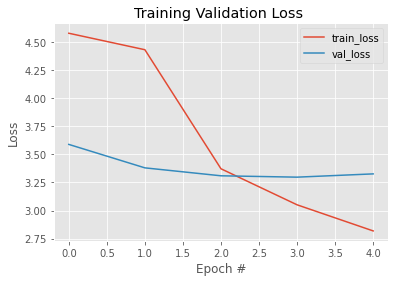

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation loss of the model

N= TRAIN_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.title("Training Validation Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

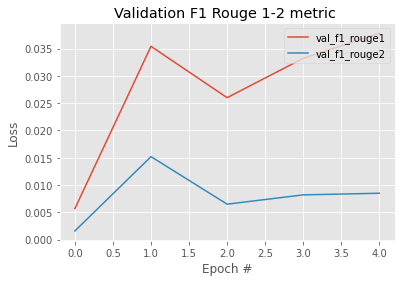

<Figure size 720x720 with 0 Axes>

In [ ]:
# plot the training and validation rouge1 metrics

N= TRAIN_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), val_rouge1_list, label="val_f1_rouge1")
plt.plot(np.arange(0, N), val_rouge2_list, label="val_f1_rouge2")
plt.title("Validation F1 Rouge 1-2 metric ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
trainer.save_model('VIT_Captioning'+'_'+model_folder)

In [ ]:
model_folder = "Greek_BERT"
image_target_size = 224

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained(model_folder + '_tokenizer',max_len=MAX_LEN)

# load the model
load_model = VisionEncoderDecoderModel.from_pretrained('VIT_Captioning'+'_'+model_folder)

In [ ]:
# display images along with the original captions as well as the predicted captions

my_images , my_titles , my_predictions = display_score_images_gr(df=validation_df,my_model=load_model,n_limit=4)

In [ ]:
# display images along with the original captions as well as the predicted captions

my_images , my_titles , my_predictions = display_score_images_gr(df=validation_df,my_model=load_model,n_limit=4)

In [ ]:
# display images along with the original captions as well as the predicted captions

my_images , my_titles , my_predictions = display_score_images_gr(df=validation_df,my_model=load_model,n_limit=4)

### Evaluating the Models

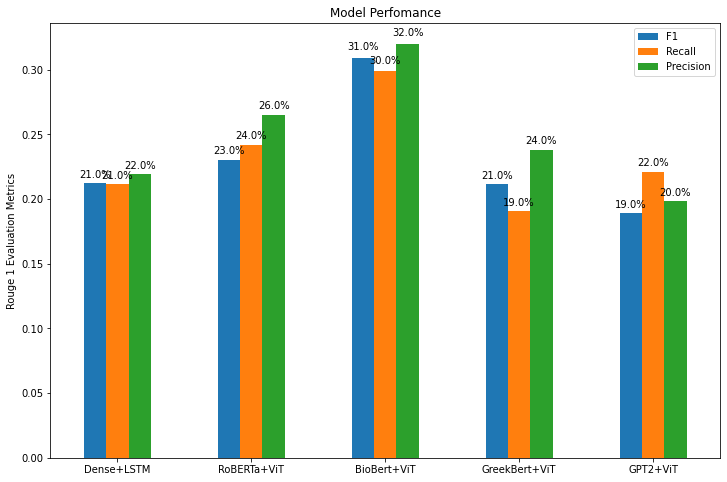

In [ ]:
# create the dataframe with the evaluation metrics from the models
df = pd.DataFrame({'F1': f1, 'Recall': recall, 'Precision':prec }, index=names)
# plot the results
ax = df.plot(kind='bar', figsize=(12, 8), rot=0, title='Model Perfomance', ylabel='Rouge 1 Evaluation Metrics')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height,2)*100}%', (x + width/2, y + height*1.02), ha='center')
plt.show()